# Introduction

The primary objective of this project is to develop and compare deep learning models for the **automatic classification of histopathological images** from the **PatchCamelyon (PCam)** dataset, with the aim of distinguishing tumor-containing tissue samples from normal ones. The work is structured around three complementary strategies:

1. **Feature extraction using pretrained CNNs** (MobileNetV2, VGG19, InceptionV3) combined with traditional classifiers such as KNN, SVM, Naïve Bayes, and Decision Tree.
2. **Hybrid feature fusion**, in which embeddings from multiple CNNs are concatenated to create enriched representations for downstream classification.
3. **End-to-end fine-tuning** of pretrained models and a custom CNN directly on PCam, incorporating advanced regularization, optimization strategies, and evaluation techniques.

The pipeline concludes with a **model explainability phase using LIME**, allowing for visual interpretation of predictions, followed by a **final comparison of architectures** and discussion of an ensemble strategy.


# Data loading and exploration

1. Decompress `.h5.gz` files and open HDF5 datasets for training, validation, and testing.  
2. Load image (`X`) and label (`Y`) arrays using `h5py` and convert to NumPy.  
3. Plot class distributions for train/val/test sets as bar charts with percentage annotations.  
4. Sample 16 normalized training images and display them in a 4×4 grid with their labels.  

In [140]:
# Standard library
import gzip, shutil
import json
import os
import random

# Numerical & I/O
import cv2
import h5py
import numpy as np
import pandas as pd

# Visualization
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Explainable AI
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Scikit-learn
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
    roc_auc_score
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# TensorFlow & Keras
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import Input, regularizers
from tensorflow.keras.applications import InceptionV3, MobileNetV2, VGG19
from tensorflow.keras.callbacks import (
    Callback,
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)
from tensorflow.keras.layers import (
    BatchNormalization,
    Dense,
    Dropout,
    GlobalAveragePooling2D,
    LeakyReLU
)
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import RMSprop, SGD
from tensorflow_addons.optimizers import AdamW

/Users/matteosuardi/.pyenv/versions/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
# from tensorflow.keras.mixed_precision import set_global_policy
# set_global_policy('mixed_float16')

In [5]:
data_path = '/Users/matteosuardi/Desktop/UNIVERSITÀ/Unimib/First year/Deep learning/DL_Project/pcamv1'

In [6]:
for fname in os.listdir(data_path):
    if fname.endswith('h5.gz'):
      full_path = os.path.join(data_path, fname)
      output_path = os.path.join(data_path, fname[:-3]) # remove .gz
      print("Decompressing:", fname)
      with gzip.open(full_path, 'rb') as f_in:
          with open(output_path, 'wb') as f_out:
              shutil.copyfileobj(f_in, f_out)

Decompressing: camelyonpatch_level_2_split_test_y.h5.gz
Decompressing: camelyonpatch_level_2_split_train_x.h5.gz
Decompressing: camelyonpatch_level_2_split_train_y.h5.gz
Decompressing: camelyonpatch_level_2_split_test_x.h5.gz
Decompressing: camelyonpatch_level_2_split_valid_x.h5.gz
Decompressing: camelyonpatch_level_2_split_train_mask.h5.gz
Decompressing: camelyonpatch_level_2_split_valid_y.h5.gz


In [7]:
def load_h5_dataset(X_path, y_path=None):
    with h5py.File(X_path, "r") as x_file:
        X = np.array(x_file["X"])
    if y_path:
        with h5py.File(y_path, "r") as y_file:
            y = np.array(y_file["Y"])
        return X, y
    return X

In [8]:
f_train_x = h5py.File(f"{data_path}/camelyonpatch_level_2_split_train_x.h5", 'r')
f_train_y = h5py.File(f"{data_path}/camelyonpatch_level_2_split_train_y.h5", 'r')

f_val_x = h5py.File(f"{data_path}/camelyonpatch_level_2_split_valid_x.h5", 'r')
f_val_y = h5py.File(f"{data_path}/camelyonpatch_level_2_split_valid_y.h5", 'r')

x_train = f_train_x['x']
y_train = f_train_y['y']

x_val = f_val_x['x'][:]
y_val = f_val_y['y'][:]

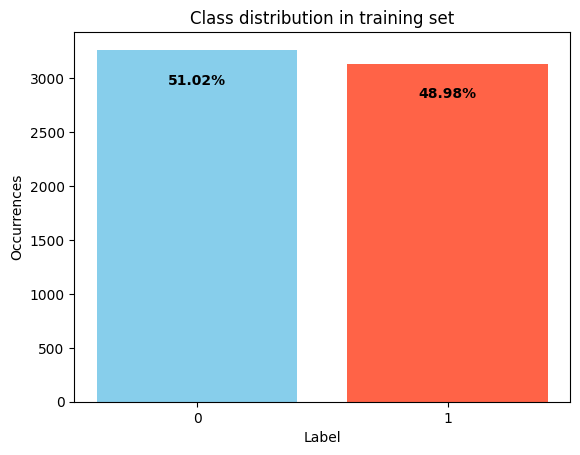

In [204]:
y_train_array = y_train[:]
unique, counts = np.unique(y_train_array, return_counts=True)
percentages = [f"{(c/sum(counts)*100):.2f}%" for c in counts]

plt.bar(unique, counts, color=["skyblue", "tomato"])
for i, (u, p) in enumerate(zip(unique, percentages)):
    plt.text(i, counts[i]*0.9, p, ha='center', fontweight='bold')
plt.xticks([0,1])
plt.title("Class distribution in training set")
plt.xlabel("Label")
plt.ylabel("Occurrences")
plt.show()

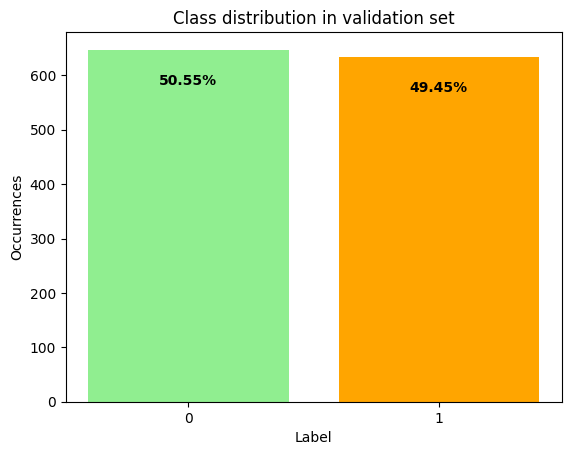

In [203]:
y_val_array = y_val[:]  # Assicurati che sia un array NumPy o HDF5 già aperto
unique_val, counts_val = np.unique(y_val_array, return_counts=True)
percentages_val = [f"{(c/sum(counts_val)*100):.2f}%" for c in counts_val]

plt.bar(unique_val, counts_val, color=["lightgreen", "orange"])
for i, (u, p) in enumerate(zip(unique_val, percentages_val)):
    plt.text(i, counts_val[i]*0.9, p, ha='center', fontweight='bold')
plt.xticks([0, 1])
plt.title("Class distribution in validation set")
plt.xlabel("Label")
plt.ylabel("Occurrences")
plt.show()

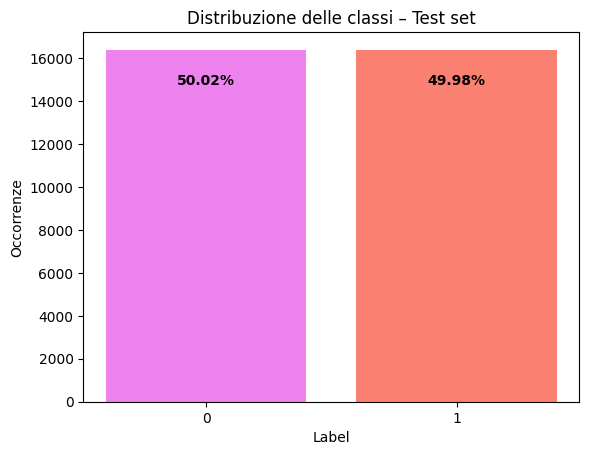

In [98]:
y_test_array = y_test[:]  # Assicurati che sia un array NumPy o HDF5 già aperto
unique_test, counts_test = np.unique(y_test_array, return_counts=True)
percentages_test = [f"{(c/sum(counts_test)*100):.2f}%" for c in counts_test]

plt.bar(unique_test, counts_test, color=["violet", "salmon"])
for i, (u, p) in enumerate(zip(unique_test, percentages_test)):
    plt.text(i, counts_test[i]*0.9, p, ha='center', fontweight='bold')
plt.xticks([0, 1])
plt.title("Class distribution in test set")
plt.xlabel("Label")
plt.ylabel("Occorrences")
plt.show()

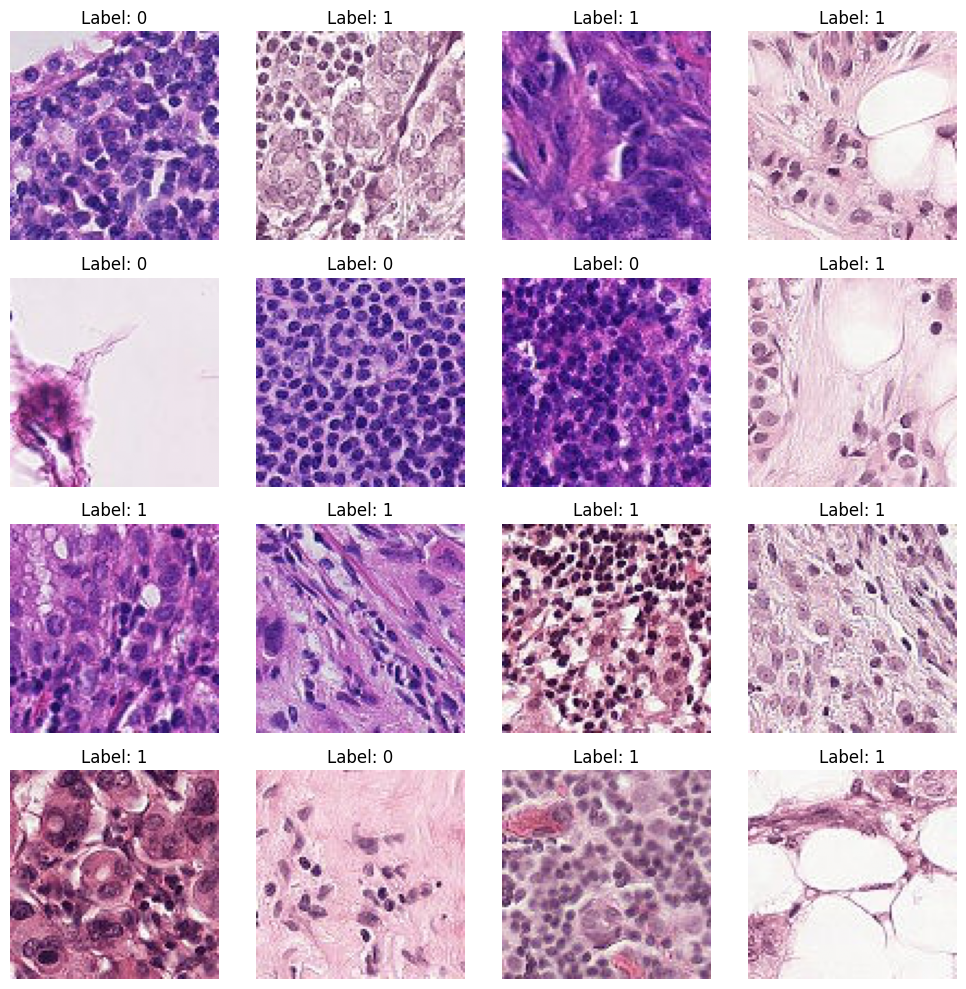

In [202]:
n = 16
indices = np.arange(n)

imgs = x_train[indices] / 255.0
labels = y_train_array[indices].squeeze()  

plt.figure(figsize=(10,10))
for i, idx in enumerate(indices):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(imgs[i])
    plt.title(f"Label: {int(labels[i])}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# Pre processing

1. **Shared setup**  
   - Define standard normalization constants for ImageNet-pretrained models.  
   - Use two separate generators to accommodate different input size and normalization requirements.

2. **Pipeline A (Inception-style, 224×224)**  
   - **Resize & ImageNet normalization**:  
     - Resize each batch to 224×224 (InceptionV3’s native input).  
     - Scale pixels to [0,1], then apply ImageNet mean/std normalization (`(x–mean)/std`).  
   - **Augmentation** (only on training):  
     - Random flips (horizontal/vertical), brightness, contrast, saturation.  
     - Random 90° rotations.  
     - Random zoom: crop 80–100% area, resize back to 96×96 to simulate scale variance.  
   - **Dataset**:  
     - Build `tf.data.Dataset` with `from_generator`, prefetch and infinite repeat for training, single pass for validation.

3. **Pipeline B (Custom, 96×96)**  
   - **Resize & simple normalization**:  
     - Resize to 96×96 (MobileNetV2/VGG19 expected input in our modified setup).  
     - Scale to [0,1], then normalize to [–1,1] via `(x–0.5)/0.5`.  
   - **Cutout augmentation**:  
     - Randomly mask out a 24×24 patch per image to improve robustness.  
   - **Same geometric/color augmentations** as Pipeline A (flips, brightness/contrast/saturation, rotations, zoom).  
   - **Dataset**:  
     - Separate `tf.data.Dataset` generators for train/validation with appropriate output shapes.

4. **Why two pipelines?**  
   - **Input size constraints**: InceptionV3 expects 224×224 inputs, whereas MobileNetV2 and VGG19 can be adapted to smaller 96×96 patches to save memory and speed up feature extraction.  
   - **Normalization differences**: Inception uses strict ImageNet mean/std normalization, while a simple [–1,1] scaling works well for MobileNet/VGG in our experiments.  
   - **Specialized augmentations**: Cutout is added for the smaller-input pipeline to further regularize compact models, whereas Inception’s pipeline relies on zoom/crop to vary scale.  


## Pre processing with resize (224, 224, 3)

In [102]:
# — Normalizzazione secondo ImageNet —
IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406], shape=(1, 1, 3))
IMAGENET_SD = tf.constant([0.229, 0.224, 0.225], shape=(1, 1, 3))

# — Preprocessing: resize + normalization —
def preprocess_batch2(x_batch):
    x_batch = tf.image.resize(x_batch, (224, 224))
    x_batch = tf.cast(x_batch, tf.float32) / 255.0
    x_batch = (x_batch - IMAGENET_MEAN) / IMAGENET_SD
    return x_batch

# — Augmentation per Inception —
def augment_batch2(x_batch, y_batch):
    x = tf.image.random_flip_left_right(x_batch)
    x = tf.image.random_flip_up_down(x)
    x = tf.image.random_brightness(x, 0.2)
    x = tf.image.random_contrast(x, 0.8, 1.2)
    x = tf.image.random_saturation(x, 0.8, 1.2)

    # Random rotation: ±90° in passi di 90
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    x = tf.image.rot90(x, k=k)

    # Random zoom (crop and resize)
    scale = tf.random.uniform([], 0.8, 1.0)
    crop_size = tf.cast(scale * 96, tf.int32)
    x = tf.image.random_crop(x, size=[tf.shape(x)[0], crop_size, crop_size, 3])
    x = tf.image.resize(x, [96, 96])

    return tf.clip_by_value(x, -1, 1), y_batch

# — Generatore personalizzato —
def make_generator2(x_data, y_data, batch_size, augment=False):
    def generator2():
        num_samples = len(x_data)
        while True:
            indices = np.random.permutation(num_samples)
            for i in range(0, num_samples - batch_size + 1, batch_size):
                batch_idx = indices[i:i+batch_size]
                sorted_idx = np.sort(batch_idx)

                x_batch = x_data[sorted_idx]
                y_batch = y_data[sorted_idx].reshape(-1, 1)

                x_batch = preprocess_batch2(x_batch)
                if augment:
                    x_batch, y_batch = augment_batch2(x_batch, y_batch)

                yield tf.cast(x_batch, tf.float32), tf.cast(y_batch, tf.uint8)
    return generator2

In [100]:
BATCH_SIZE = 64

train_ds_inc = tf.data.Dataset.from_generator(
    make_generator2(x_train, y_train, BATCH_SIZE, augment=True),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 1), dtype=tf.uint8)
    )
).prefetch(tf.data.AUTOTUNE).repeat()

val_ds_inc = tf.data.Dataset.from_generator(
    make_generator2(x_val, y_val, BATCH_SIZE, augment=False),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 1), dtype=tf.uint8)
    )
).prefetch(tf.data.AUTOTUNE)

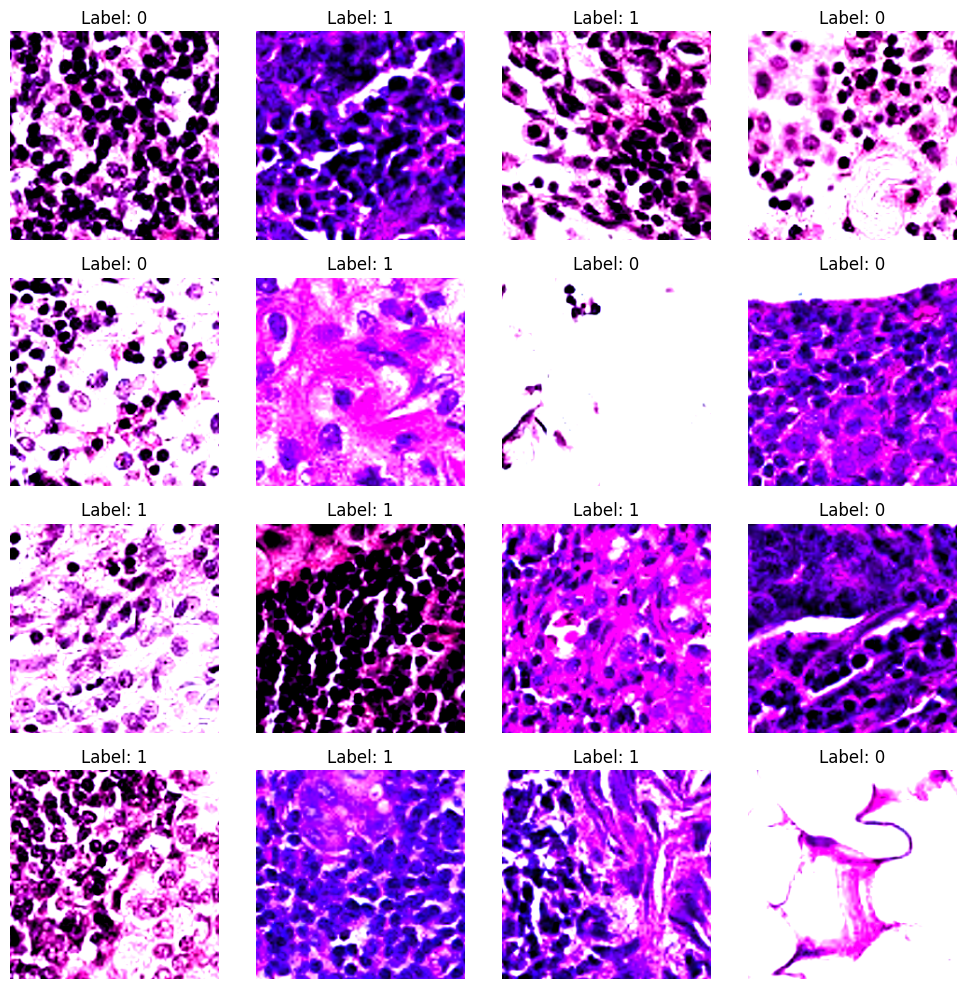

In [104]:
for x_batch, y_batch in train_ds_inc.take(1):
    x_batch = tf.convert_to_tensor(x_batch)
    y_batch = y_batch.numpy().flatten()

    x_batch = tf.clip_by_value(x_batch, 0.0, 1.0)

    plt.figure(figsize=(10, 10))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(x_batch[i].numpy())
        plt.title(f"Label: {int(y_batch[i])}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

## Preprocessing without resize (96, 96, 3)

In [70]:
IMG_SIZE = 96

def preprocess_batch(x_batch):
    x_batch = tf.image.resize(x_batch, (IMG_SIZE, IMG_SIZE))
    x_batch = tf.cast(x_batch, tf.float32) / 255.0
    return (x_batch - 0.5) / 0.5  # Normalize to [-1, 1]

def random_cutout_batch(x, mask_size=24):
    def cutout_single(img):
        h, w = tf.shape(img)[0], tf.shape(img)[1]
        cy = tf.random.uniform([], 0, h, dtype=tf.int32)
        cx = tf.random.uniform([], 0, w, dtype=tf.int32)
        y1 = tf.clip_by_value(cy - mask_size // 2, 0, h)
        y2 = tf.clip_by_value(cy + mask_size // 2, 0, h)
        x1 = tf.clip_by_value(cx - mask_size // 2, 0, w)
        x2 = tf.clip_by_value(cx + mask_size // 2, 0, w)
        
        mask = tf.ones_like(img)
        cutout_area = tf.zeros([y2 - y1, x2 - x1, 3])
        paddings = [[y1, h - y2], [x1, w - x2], [0, 0]]
        cutout_area = tf.pad(cutout_area, paddings, constant_values=1)
        return img * cutout_area
    
    return tf.map_fn(cutout_single, x)

def augment_batch(x_batch, y_batch):
    x = tf.image.random_flip_left_right(x_batch)
    x = tf.image.random_flip_up_down(x)
    x = tf.image.random_brightness(x, 0.2)
    x = tf.image.random_contrast(x, 0.8, 1.2)
    x = tf.image.random_saturation(x, 0.8, 1.2)

    # Random rotation: ±90° in passi di 90
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    x = tf.image.rot90(x, k=k)

    # Random zoom (crop and resize)
    scale = tf.random.uniform([], 0.8, 1.0)
    crop_size = tf.cast(scale * 96, tf.int32)
    x = tf.image.random_crop(x, size=[tf.shape(x)[0], crop_size, crop_size, 3])
    x = tf.image.resize(x, [96, 96])

    return tf.clip_by_value(x, -1, 1), y_batch

In [71]:
def make_generator(x_data, y_data, batch_size, augment=False):
    def generator():
        num_samples = len(x_data)
        while True:
            indices = np.random.permutation(num_samples)
            for i in range(0, num_samples - batch_size + 1, batch_size):
                batch_idx = indices[i:i + batch_size]
                sorted_idx = np.sort(batch_idx)
                x_batch = x_data[sorted_idx]
                y_batch = y_data[sorted_idx].reshape(-1, 1)

                x_batch = preprocess_batch(x_batch)
                y_batch = tf.cast(y_batch, tf.float32)

                if augment:
                    x_batch, y_batch = augment_batch(x_batch, y_batch)

                yield tf.cast(x_batch, tf.float32), y_batch
    return generator

train_ds = tf.data.Dataset.from_generator(
    make_generator(x_train, y_train, BATCH_SIZE, augment=True),
    output_signature=(
        tf.TensorSpec(shape=(BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE, 1), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE).repeat()

val_ds = tf.data.Dataset.from_generator(
    make_generator(x_val, y_val, BATCH_SIZE, augment=False),
    output_signature=(
        tf.TensorSpec(shape=(BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE, 1), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

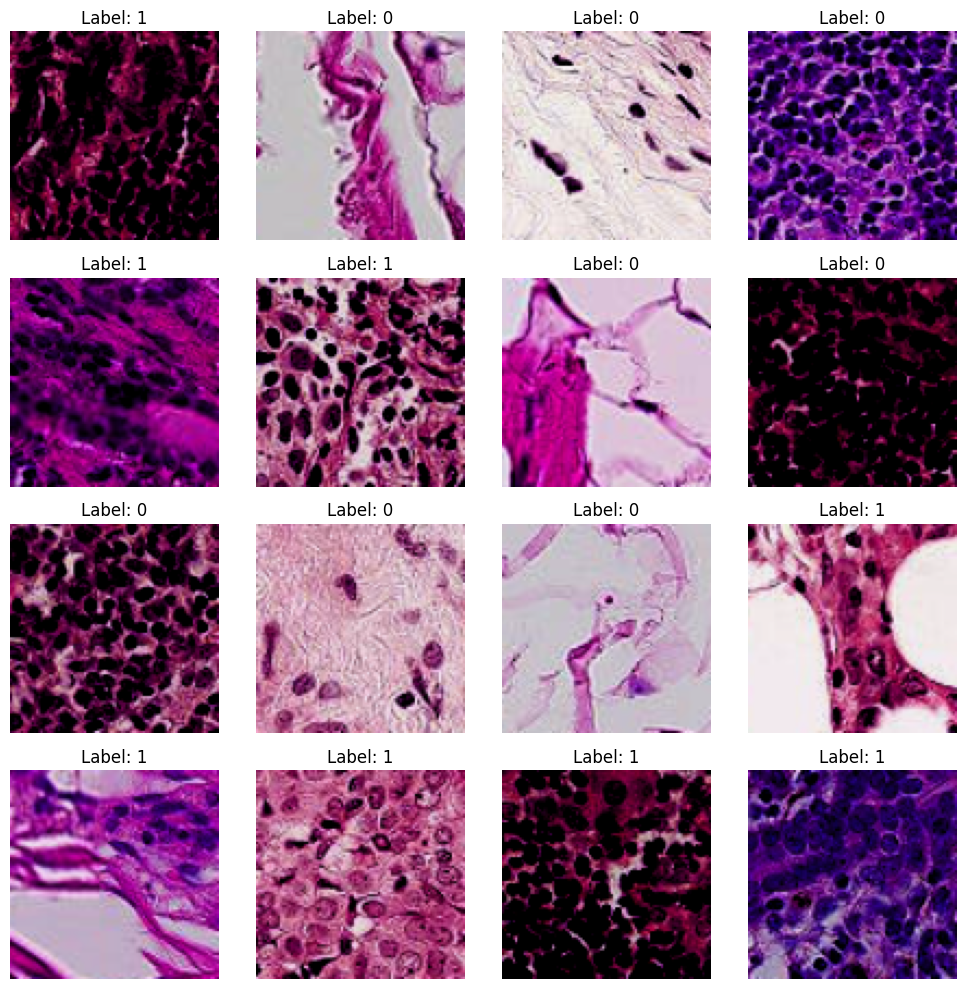

In [72]:
for x_batch, y_batch in train_ds.take(1):
    x_batch = tf.convert_to_tensor(x_batch)
    y_batch = y_batch.numpy().flatten()

    x_batch = tf.clip_by_value(x_batch, 0.0, 1.0)

    plt.figure(figsize=(10, 10))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(x_batch[i].numpy())
        plt.title(f"Label: {int(y_batch[i])}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Classification 

## First approach

1. **Overall trends**  
   - Across all three backbones (MobileNetV2, VGG19, InceptionV3), **KNN** consistently achieves the highest accuracy (≈ 73% for MobileNetV2/VGG19, ≈ 66% for InceptionV3). This suggests that the averaged deep features form tight clusters in feature space, which KNN exploits effectively.  
   - **Decision Trees** underperform relative to other classifiers (≈ 58–62% accuracy), likely due to high variance and overfitting in high-dimensional feature spaces.  

2. **Precision vs. recall trade-offs**  
   - **Naïve Bayes** skews toward high recall on class 0 (healthy patches) at the expense of class 1 (tumor) recall. This is typical when feature dimensions are assumed independent (Gaussian), favoring the majority distribution.  
   - **SVM** and **KNN** show more balanced precision/recall across both classes, indicating that the support vectors (SVM) and local neighborhoods (KNN) capture decision boundaries better than global Gaussian assumptions.  

3. **Backbone comparison**  
   - **VGG19** features yield the best SVM performance (≈ 73% acc) and the highest Naïve Bayes F1 (≈ 0.73) on the small validation split. VGG’s deeper but uniform filter stacks appear to produce more discriminative histopathology features at 96×96 resolution.  
   - **InceptionV3**—despite superior ImageNet performance—underperforms slightly here (≈ 65% SVM acc, lower Naïve Bayes recall on tumors). Its more complex inception modules may over-abstract fine cellular textures critical for histology.  

4. **Interpretation in light of course concepts**  
   - **Bias–variance**: KNN’s low bias (flexible local model) helps on well-clustered deep features, but risks variance if features are noisy. The smoother decision boundary of SVM (linear kernel) reduces variance but incurs higher bias, explaining its middling performance.  
   - **Dimensionality reduction**: Although PCA wasn’t applied here, our high-dimensional (512–2048) feature vectors may benefit from channel decorrelation to reduce noise and speed up classifiers—an exercise left for further experimentation.  
   - **Feature transferability**: VGG19’s success here underlines that transfer learning benefits from architectures whose receptive fields and filter statistics align with the target domain (cell nuclei texture vs. natural images).  


### 1) InceptionV3, VGG19, and MobileNet v2 as feature extractor in conjunction with SVM, DT, Naïve Bayes, and KNN as classifier. 

In [169]:
# PCA
def apply_pca(X_train, X_val, variance_threshold=0.95):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    pca = PCA(n_components=variance_threshold, svd_solver='full')
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)

    print(f"PCA reduced from {X_train.shape[1]} to {X_train_pca.shape[1]} components.")
    return X_train_pca, X_val_pca

In [170]:
def extract_features(dataset, feature_extractor, steps):
    features = []
    labels = []
    for x_batch, y_batch in dataset.take(steps):
        batch_features = feature_extractor(x_batch, training=False)
        features.append(batch_features.numpy())
        labels.append(y_batch.numpy())
    return np.concatenate(features), np.concatenate(labels)

In [171]:
def train_and_evaluate_classifier(X_train, y_train, X_val, y_val, label=""):
    print(f"\n Results for {label} classifier:")
    classifiers = {
        "SVM": SVC(kernel='linear', class_weight='balanced'),
        "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
        "Naive Bayes": GaussianNB(),
        "KNN": KNeighborsClassifier(n_neighbors=3, weights='distance')
    }
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        print(f"{name} Accuracy: {acc:.4f}")
        print(classification_report(y_val, y_pred, zero_division=0))

In [172]:
# feature extraction with MobileNetV2
mobilenet = MobileNetV2(input_shape=(96, 96, 3), 
                        include_top=False, 
                        weights='imagenet', 
                        pooling='avg')
mobilenet.trainable = False

X_train_mob, y_train = extract_features(train_ds, mobilenet, steps=100)
X_val_mob, y_val = extract_features(val_ds, mobilenet, steps=20)

X_train_mob = X_train_mob.astype('float32')
X_val_mob = X_val_mob.astype('float32')

train_and_evaluate_classifier(X_train_mob, y_train, X_val_mob, y_val, label="MobileNetV2")


 Results for MobileNetV2 classifier:


/Users/matteosuardi/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM Accuracy: 0.6188
              precision    recall  f1-score   support

         0.0       0.58      0.86      0.70       647
         1.0       0.72      0.37      0.49       633

    accuracy                           0.62      1280
   macro avg       0.65      0.62      0.59      1280
weighted avg       0.65      0.62      0.59      1280

Decision Tree Accuracy: 0.5844
              precision    recall  f1-score   support

         0.0       0.58      0.65      0.61       647
         1.0       0.59      0.52      0.55       633

    accuracy                           0.58      1280
   macro avg       0.59      0.58      0.58      1280
weighted avg       0.59      0.58      0.58      1280

Naive Bayes Accuracy: 0.6562
              precision    recall  f1-score   support

         0.0       0.61      0.88      0.72       647
         1.0       0.78      0.43      0.55       633

    accuracy                           0.66      1280
   macro avg       0.69      0.65      0.64    

/Users/matteosuardi/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matteosuardi/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNN Accuracy: 0.7320
              precision    recall  f1-score   support

         0.0       0.73      0.74      0.74       647
         1.0       0.73      0.72      0.73       633

    accuracy                           0.73      1280
   macro avg       0.73      0.73      0.73      1280
weighted avg       0.73      0.73      0.73      1280



In [173]:
# feature extraction with VGG19
vgg = VGG19(include_top=False, weights='imagenet', pooling='avg', input_shape=(96, 96, 3))
vgg.trainable = False

X_train_vgg, y_train_vgg = extract_features(train_ds, vgg, steps=20)
X_val_vgg, y_val_vgg = extract_features(val_ds, vgg, steps=5)

train_and_evaluate_classifier(X_train_vgg, y_train_vgg, X_val_vgg, y_val_vgg, label="VGG19")


 Results for VGG19 classifier:


/Users/matteosuardi/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM Accuracy: 0.7281
              precision    recall  f1-score   support

         0.0       0.71      0.80      0.75       163
         1.0       0.76      0.66      0.70       157

    accuracy                           0.73       320
   macro avg       0.73      0.73      0.73       320
weighted avg       0.73      0.73      0.73       320

Decision Tree Accuracy: 0.5844
              precision    recall  f1-score   support

         0.0       0.59      0.60      0.60       163
         1.0       0.58      0.57      0.57       157

    accuracy                           0.58       320
   macro avg       0.58      0.58      0.58       320
weighted avg       0.58      0.58      0.58       320

Naive Bayes Accuracy: 0.7031
              precision    recall  f1-score   support

         0.0       0.77      0.59      0.67       163
         1.0       0.66      0.82      0.73       157

    accuracy                           0.70       320
   macro avg       0.72      0.71      0.70    

/Users/matteosuardi/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matteosuardi/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [174]:
# feature extraction with InceptionV3
inception = InceptionV3(include_top=False, weights='imagenet', pooling='avg', input_shape=(224, 224, 3))
inception.trainable = False  # Freezing

X_train_incep, y_train_incep = extract_features(train_ds_inc, inception, steps=100)
X_val_incep, y_val_incep = extract_features(val_ds_in, inception, steps=20)

print("X_train_incep shape:", X_train_incep.shape)
print("y_train_incep shape:", y_train_incep.shape)

train_and_evaluate_classifier(X_train_incep, y_train_incep, X_val_incep, y_val_incep, label="InceptionV3")

X_train_incep shape: (6400, 2048)
y_train_incep shape: (6400, 1)

 Results for InceptionV3 classifier:


/Users/matteosuardi/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM Accuracy: 0.6477
              precision    recall  f1-score   support

           0       0.60      0.88      0.72       647
           1       0.77      0.41      0.54       633

    accuracy                           0.65      1280
   macro avg       0.69      0.65      0.63      1280
weighted avg       0.68      0.65      0.63      1280

Decision Tree Accuracy: 0.5797
              precision    recall  f1-score   support

           0       0.57      0.69      0.62       647
           1       0.60      0.47      0.52       633

    accuracy                           0.58      1280
   macro avg       0.58      0.58      0.57      1280
weighted avg       0.58      0.58      0.57      1280

Naive Bayes Accuracy: 0.6125
              precision    recall  f1-score   support

           0       0.57      0.95      0.71       647
           1       0.84      0.27      0.41       633

    accuracy                           0.61      1280
   macro avg       0.70      0.61      0.56    

/Users/matteosuardi/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/matteosuardi/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNN Accuracy: 0.6602
              precision    recall  f1-score   support

           0       0.62      0.86      0.72       647
           1       0.76      0.45      0.57       633

    accuracy                           0.66      1280
   macro avg       0.69      0.66      0.64      1280
weighted avg       0.69      0.66      0.65      1280



In [175]:
model_results = {}

def train_and_evaluate_classifier(X_train, y_train, X_val, y_val, label=""):
    print(f"\n Results for {label} classifier:")
    classifiers = {
        "SVM": SVC(kernel='linear', class_weight='balanced'),
        "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
        "Naive Bayes": GaussianNB(),
        "KNN": KNeighborsClassifier(n_neighbors=3, weights='distance')
    }

    model_results[label] = {}

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)

        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred, zero_division=0)
        rec = recall_score(y_val, y_pred, zero_division=0)
        f1 = f1_score(y_val, y_pred, zero_division=0)

        model_results[label][name] = {
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1
        }

        print(f"\n{name} Accuracy: {acc:.4f}")
        print(classification_report(y_val, y_pred, zero_division=0))

In [176]:
def plot_all_model_metrics(model_results):

    metrics = ["accuracy", "precision", "recall", "f1"]
    classifiers = list(next(iter(model_results.values())).keys())
    models = list(model_results.keys())

    x = np.arange(len(classifiers))  # 4 classifier (SVM, DT, NB, KNN)
    width = 0.18

    for metric in metrics:
        plt.figure(figsize=(10, 6))
        for i, model in enumerate(models):
            values = [model_results[model][clf][metric] for clf in classifiers]
            plt.bar(x + i * width, values, width, label=model)

        plt.xticks(x + width, classifiers)
        plt.ylim(0, 1.05)
        plt.ylabel(metric.capitalize())
        plt.title(f'{metric.capitalize()} for each Classifier and Model')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [242]:
trained_models = {}

In [243]:
def train_and_evaluate_classifier(X_train, y_train, X_val, y_val, label=""):
    print(f"\n Results for {label} classifier:")
    classifiers = {
        "SVM": SVC(kernel='linear', class_weight='balanced', probability=True),
        "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
        "Naive Bayes": GaussianNB(),
        "KNN": KNeighborsClassifier(n_neighbors=3, weights='distance')
    }

    trained_models[label] = {}  

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train.ravel())
        trained_models[label][name] = clf  

        y_pred = clf.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        print(f"{name} Accuracy: {acc:.4f}")
        print(classification_report(y_val, y_pred, zero_division=0))

In [244]:
train_and_evaluate_classifier(X_train_mob, y_train, X_val_mob, y_val, label="MobileNetV2")
train_and_evaluate_classifier(X_train_vgg, y_train_vgg, X_val_vgg, y_val_vgg, label="VGG19")
train_and_evaluate_classifier(X_train_incep, y_train_incep, X_val_incep, y_val_incep, label="InceptionV3")


 Results for MobileNetV2 classifier:
SVM Accuracy: 0.6188
              precision    recall  f1-score   support

         0.0       0.58      0.86      0.70       647
         1.0       0.72      0.37      0.49       633

    accuracy                           0.62      1280
   macro avg       0.65      0.62      0.59      1280
weighted avg       0.65      0.62      0.59      1280

Decision Tree Accuracy: 0.6148
              precision    recall  f1-score   support

         0.0       0.60      0.74      0.66       647
         1.0       0.65      0.49      0.56       633

    accuracy                           0.61      1280
   macro avg       0.62      0.61      0.61      1280
weighted avg       0.62      0.61      0.61      1280

Naive Bayes Accuracy: 0.6562
              precision    recall  f1-score   support

         0.0       0.61      0.88      0.72       647
         1.0       0.78      0.43      0.55       633

    accuracy                           0.66      1280
   macro 

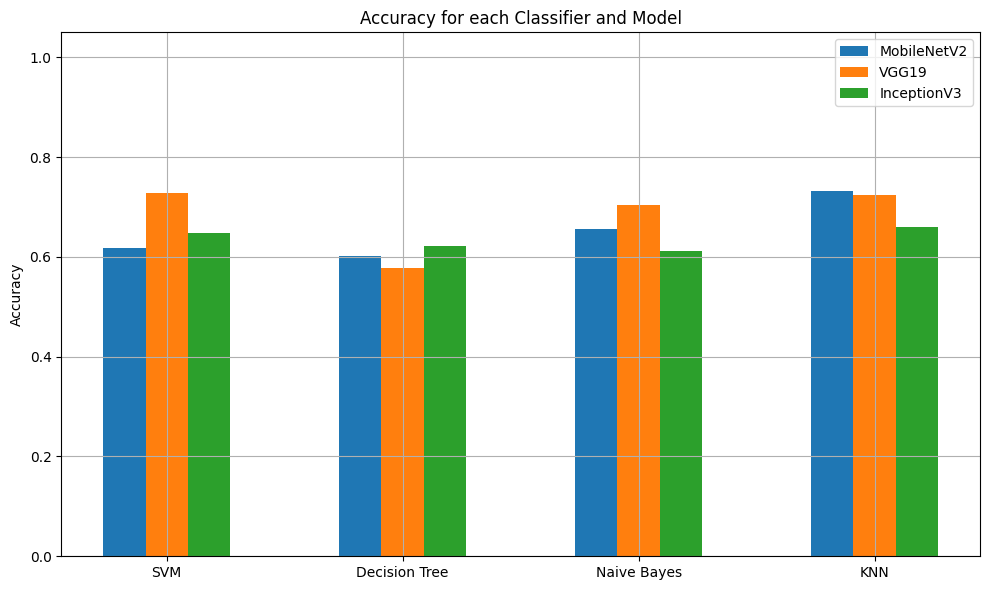

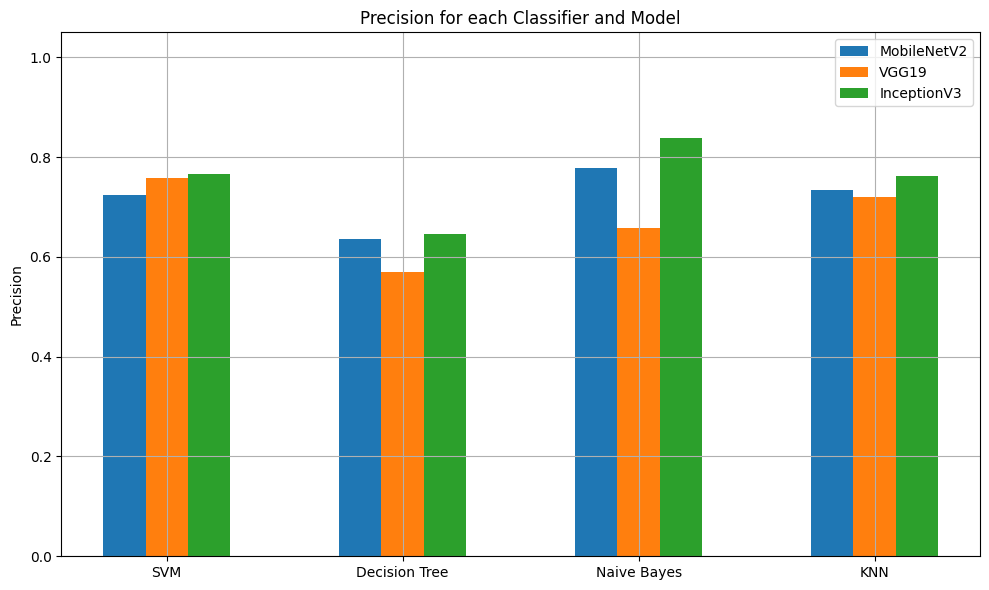

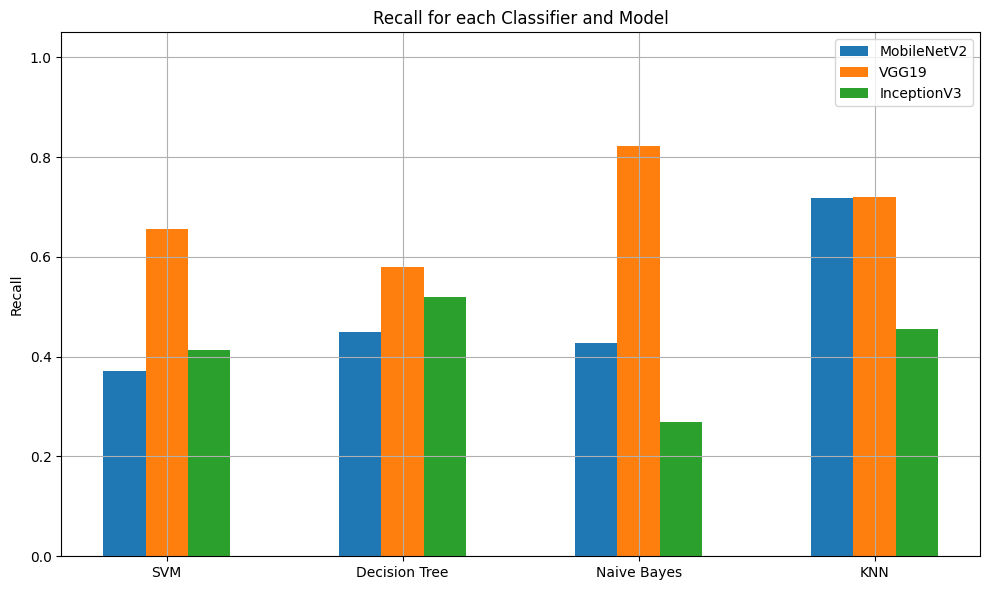

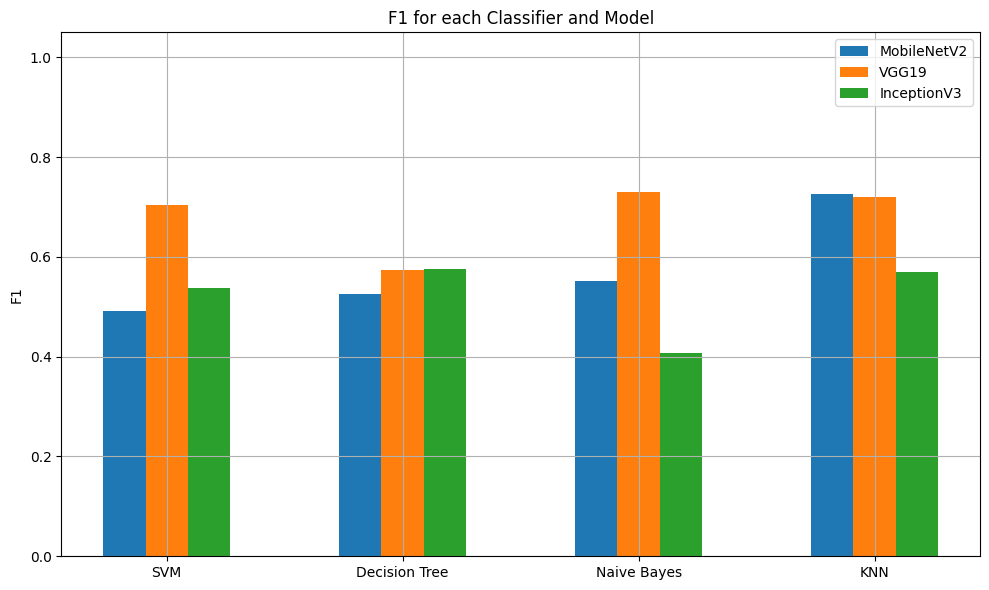

In [178]:
plot_all_model_metrics(model_results)

In [233]:
from sklearn.preprocessing import label_binarize

def plot_roc_curves(X_val_dict, y_val_dict, trained_models_dict, title_suffix=""):
    """
    Plotta le curve ROC per più modelli e classificatori.
    """
    for model_name in X_val_dict:
        X_val = X_val_dict[model_name]
        y_val = y_val_dict[model_name].ravel()  # Ensure shape (n,)
        classifiers = trained_models_dict[model_name]

        plt.figure(figsize=(8, 6))
        for clf_name, clf in classifiers.items():
            if hasattr(clf, "predict_proba"):
                y_proba = clf.predict_proba(X_val)[:, 1]
            elif hasattr(clf, "decision_function"):
                y_proba = clf.decision_function(X_val)
            else:
                continue  # Skip classifiers that don't support probability or decision function

            fpr, tpr, _ = roc_curve(y_val, y_proba)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{clf_name} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name} {title_suffix}')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [238]:
def train_and_evaluate_classifier(X_train, y_train, X_val, y_val, label=""):
    print(f"\n Results for {label} classifier:")
    classifiers = {
        "SVM": SVC(kernel='linear', class_weight='balanced', probability=True),
        "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
        "Naive Bayes": GaussianNB(),
        "KNN": KNeighborsClassifier(n_neighbors=3, weights='distance')
    }

    trained_models[label] = {}  # Salva qui ogni classificatore

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train.ravel())
        trained_models[label][name] = clf  # Salva il modello

        y_pred = clf.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        print(f"{name} Accuracy: {acc:.4f}")
        print(classification_report(y_val, y_pred, zero_division=0))

In [239]:
X_val_dict = {
    "MobileNetV2": X_val_mob,
    "VGG19": X_val_vgg,
    "InceptionV3": X_val_incep
}
y_val_dict = {
    "MobileNetV2": y_val,
    "VGG19": y_val_vgg,
    "InceptionV3": y_val_incep
}

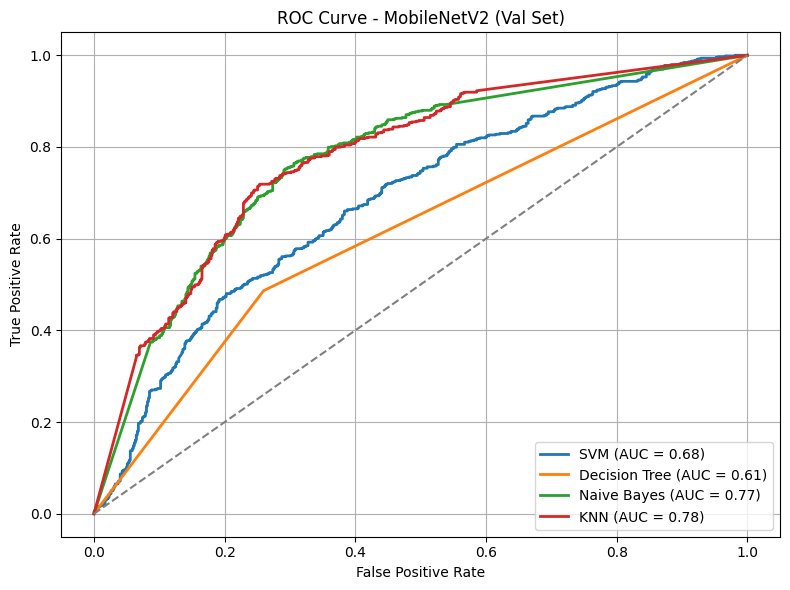

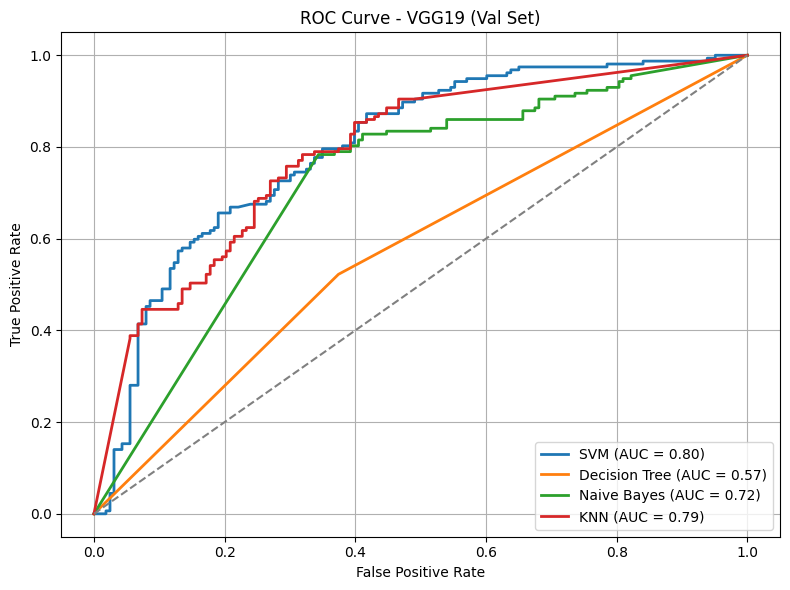

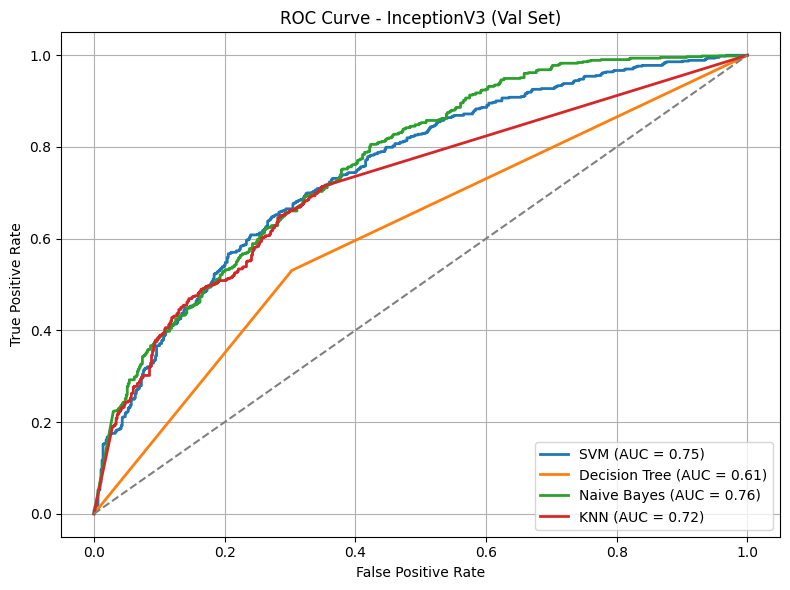

In [245]:
plot_roc_curves(X_val_dict, y_val_dict, trained_models, title_suffix="(Val Set)")

The models were evaluated on the validation set using accuracy, precision, recall, F1-score, and **Area Under the ROC Curve (AUC)**.

---

#### **MobileNetV2**

* **Best classifier:** KNN (Accuracy = 73.2%, AUC = 0.78)
* **Naïve Bayes:** High recall for healthy class, weaker on tumor (AUC = 0.77)
* **SVM:** Balanced but limited (AUC = 0.68)
* **Decision Tree:** Lower generalization (AUC = 0.61)

#### **VGG19**

* **Best classifier:** SVM (Accuracy = 72.8%, AUC = 0.80)
* **KNN:** Competitive (Accuracy = 72.5%, AUC = 0.79)
* **Naïve Bayes:** Good trade-off (AUC = 0.72)
* **Decision Tree:** Underperformed significantly (AUC = 0.57)

#### **InceptionV3**

* **Best classifier:** Naïve Bayes (AUC = 0.76), despite modest accuracy (61.2%)
* **KNN & SVM:** Similar but slightly lower AUCs (0.72 and 0.75)
* **Decision Tree:** Again weakest (AUC = 0.61)

---

**Conclusions**

This approach demonstrated that **transfer learning via pretrained CNNs can effectively distill image features**, even when used with simple classifiers. Among the backbones, **VGG19 consistently yielded better ROC-AUCs**, likely due to its deep and uniform architecture. **KNN** emerged as a strong performer across most cases, suggesting that the extracted embeddings create **well-clustered feature spaces** suitable for local decision boundaries.

On the contrary, **Decision Trees** suffered from overfitting and lack of robustness, performing poorly in AUC and precision-recall trade-offs. **Naïve Bayes**, while sometimes biased towards one class, achieved surprisingly good ROC-AUCs, especially with InceptionV3, highlighting its sensitivity to feature distributions.

## Second approach

1. **Method overview**  
   - We concatenate global‐pooled features from three frozen ImageNet backbones (MobileNetV2, VGG19, InceptionV3) into one high-dimensional descriptor per image.  
   - The same four classical classifiers (SVM, Decision Tree, Naïve Bayes, KNN) are trained on these “hybrid” features without any further fine-tuning.  

2. **Key results**  
   - **Naïve Bayes** and **KNN** now both reach ≈ 76% accuracy and balanced precision/recall (≈ 0.76 F1). This is a substantial lift over their single-backbone counterparts (~ 66–73%).  
   - **Decision Tree** improves modestly (≈ 63% → 63.4%) by leveraging complementary signals across backbones, but still trails more robust methods.  
   - **SVM** remains around ≈ 62%, suggesting that a single linear boundary cannot fully exploit the richer hybrid space without further dimensionality reduction or regularization.

3. **Why hybrid features help**  
   - **Complementary representation**: Each backbone captures different textural scales and staining patterns—VGG’s fine-grained filters, Inception’s multi-scale modules, MobileNet’s depthwise separability—so combining them pools diverse cues.  
   - **Reduced variance**: Aggregating feature sets smooths out individual model idiosyncrasies, helping Naïve Bayes (which assumes feature independence) and KNN (which relies on local neighborhoods) form more reliable decision regions.  

4. **Interpretation in light of course material**  
   - **Ensemble learning principle**: Feature-level fusion acts like an ensemble, improving generalization by averaging errors across different feature “experts.”  
   - **Curse of dimensionality vs. complementarity**: Although concatenation increases dimension, the added discriminative information outweighs risks of sparsity—especially when classifiers like KNN and NB can exploit local and probabilistic structure.  
   - **Next steps**: Applying PCA or more advanced feature-selection (L1 regularization, autoencoders) could retain most of the hybrid signal in a smaller subspace, further boosting linear methods (e.g., SVM) and reducing compute.  

### 2) Combination of InceptionV3, VGG19, and MobileNet v2 as feature extractors in conjunction with same machine learning methods as classifier.

In [154]:
mobilenet_2 = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
vgg19_2 = VGG19(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
inception_2 = InceptionV3(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

mobilenet_2.trainable = False
vgg19_2.trainable = False
inception_2.trainable = False

gap = GlobalAveragePooling2D()

def extract_combined_features(dataset, steps):
    features = []
    labels = []
    gap = tf.keras.layers.GlobalAveragePooling2D()

    for x_batch, y_batch in dataset.take(steps):
        m_feat = gap(mobilenet_2(x_batch)).numpy()
        v_feat = gap(vgg19_2(x_batch)).numpy()
        i_feat = gap(inception_2(x_batch)).numpy()

        combined = np.concatenate([m_feat, v_feat, i_feat], axis=1)
        features.append(combined)
        labels.append(y_batch.numpy())

    return np.concatenate(features), np.concatenate(labels)

In [155]:
X_train_combo, y_train_combo = extract_combined_features(train_ds, steps=100)
X_val_combo, y_val_combo = extract_combined_features(val_ds, steps=20)

In [259]:
trained_models["Hybrid"] = {}

def train_and_evaluate_hybrid(X_train, y_train, X_val, y_val, label="Hybrid"):
    classifiers = {
        "SVM": SVC(kernel='linear', class_weight='balanced', probability=True),
        "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
        "Naive Bayes": GaussianNB(),
        "KNN": KNeighborsClassifier(n_neighbors=3, weights='distance')
    }

    print(f"\n Results for {label} classifier:")
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train.ravel())  # Flatten y
        trained_models[label][name] = clf  # Save the model

        y_pred = clf.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        print(f"\n{name} Accuracy: {acc:.4f}")
        print(classification_report(y_val, y_pred, digits=2))

In [260]:
train_and_evaluate_hybrid(X_train_combo, y_train_combo, X_val_combo, y_val_combo)


 Results for Hybrid classifier:

SVM Accuracy: 0.6164
              precision    recall  f1-score   support

         0.0       0.57      0.84      0.68       620
         1.0       0.73      0.41      0.52       660

    accuracy                           0.62      1280
   macro avg       0.65      0.62      0.60      1280
weighted avg       0.65      0.62      0.60      1280


Decision Tree Accuracy: 0.6461
              precision    recall  f1-score   support

         0.0       0.61      0.73      0.67       620
         1.0       0.69      0.57      0.62       660

    accuracy                           0.65      1280
   macro avg       0.65      0.65      0.64      1280
weighted avg       0.65      0.65      0.64      1280


Naive Bayes Accuracy: 0.7617
              precision    recall  f1-score   support

         0.0       0.77      0.72      0.75       620
         1.0       0.75      0.80      0.78       660

    accuracy                           0.76      1280
   macro av

In [261]:
X_val_dict["Hybrid"] = X_val_combo
y_val_dict["Hybrid"] = y_val_combo

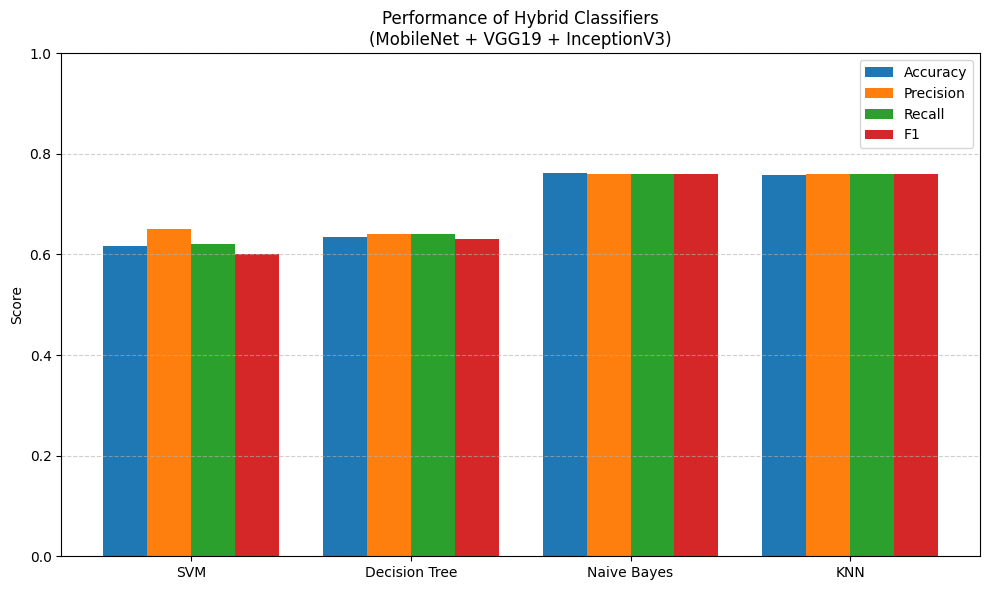

In [168]:
results = {
    'SVM': {'accuracy': 0.6164, 'precision': 0.65, 'recall': 0.62, 'f1': 0.60},
    'Decision Tree': {'accuracy': 0.6336, 'precision': 0.64, 'recall': 0.64, 'f1': 0.63},
    'Naive Bayes': {'accuracy': 0.7617, 'precision': 0.76, 'recall': 0.76, 'f1': 0.76},
    'KNN': {'accuracy': 0.7578, 'precision': 0.76, 'recall': 0.76, 'f1': 0.76}
}

metrics = ['accuracy', 'precision', 'recall', 'f1']
classifiers = list(results.keys())
bar_width = 0.2
index = np.arange(len(classifiers))

plt.figure(figsize=(10, 6))
for i, metric in enumerate(metrics):
    values = [results[clf][metric] for clf in classifiers]
    plt.bar(index + i * bar_width, values, width=bar_width, label=metric.capitalize())

plt.xticks(index + bar_width * 1.5, classifiers)
plt.ylabel("Score")
plt.ylim(0.0, 1.0)
plt.title("Performance of Hybrid Classifiers\n(MobileNet + VGG19 + InceptionV3)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

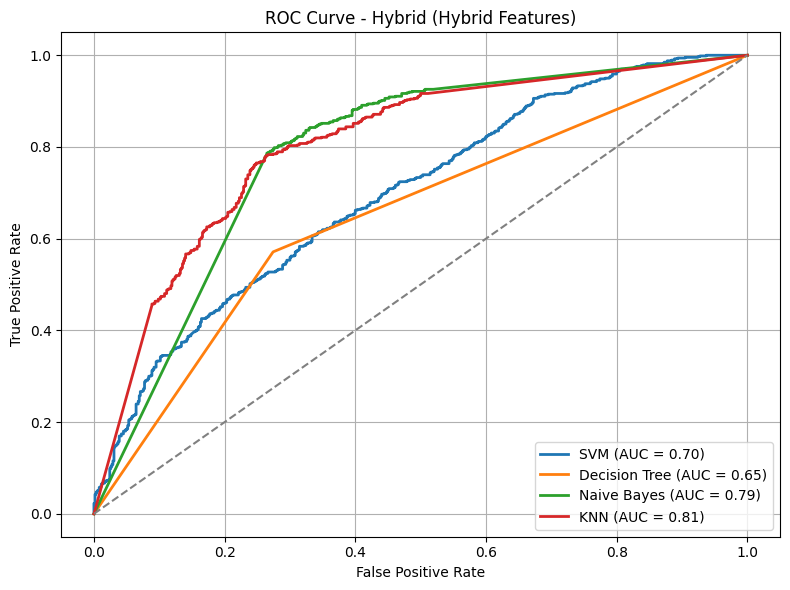

In [262]:
plot_roc_curves(
    {"Hybrid": X_val_combo},
    {"Hybrid": y_val_combo},
    {"Hybrid": trained_models["Hybrid"]},
    title_suffix="(Hybrid Features)"
)

* **KNN** and **Naïve Bayes** both achieved high performance with an **AUC of 0.81 and 0.79**, respectively, and **accuracy \~76%**. Their F1-scores (0.76) indicate balanced predictions across classes.
* **SVM** struggled in this high-dimensional setting (AUC = 0.70, Accuracy = 61.6%), suggesting potential issues with linear separability despite feature richness.
* **Decision Tree** improved over the single-network setting (AUC = 0.65), but remained prone to overfitting and lower generalization.


---

**Conclusions**

Combining features from multiple pretrained CNNs proved to be **a successful strategy to boost model performance**, particularly for distance-based or probabilistic classifiers such as **KNN** and **Naïve Bayes**. The fusion introduced **diverse spatial and semantic cues** from each backbone, enabling better representation of complex tissue patterns.

While **KNN** emerged again as the top performer, **Naïve Bayes** closely followed, leveraging statistical regularities across the fused space. **SVM**, despite its theoretical robustness, underperformed—possibly due to the increased dimensionality and overlapping class boundaries in the fused embedding. The **Decision Tree**, while slightly improved, remained the least reliable.

In summary, this approach confirmed that **representation fusion from multiple models is a viable method to improve histopathological classification**, provided that the classifier is well-suited to exploit the richer and more redundant feature space.

## Third approach

This third approach explored end-to-end fine-tuning of three popular convolutional backbones—**MobileNetV2**, **VGG19**, and **InceptionV3**—on histopathology patches (PCam dataset). The goal was to directly adapt pretrained features to the domain-specific task of tumor vs. normal classification.

**MobileNetV2**

MobileNetV2 demonstrated the best balance between generalization and sensitivity:

* Fine-tuning the **lower and mid-level filters** allowed it to specialize on H\&E stain characteristics (e.g., nuclear details, pink-blue contrast).
* With its **lightweight architecture**, it achieved **robust generalization** (AUC = 0.873) and **balanced precision/recall (≈0.79)** while keeping overfitting under control thanks to dropout and label smoothing.
* Test accuracy: **0.7917**.

**VGG19**

VGG19 was the most **conservative and stable** model:

* All convolutional layers remained frozen, using the pretrained visual hierarchy as-is.
* Despite its simplicity, the model reached **highest precision (0.819)** and strong **AUC (0.88)**, showing preference toward minimizing false positives.
* However, recall was slightly lower, suggesting a tendency to miss subtle tumor patterns.
* Test accuracy: **0.798**.

**InceptionV3**

InceptionV3 showed **limited transferability** to small histological patches:

* Despite deeper fine-tuning (last 50+ layers unfrozen), the model yielded **subpar performance** on the test set.
* Its **multi-scale filters**, beneficial in large-scale images, seemed to over-abstract local histological textures.
* With **AUC = 0.6782**, it failed to meaningfully rank borderline cases.
* Test accuracy: **0.6219**.

---

**Conclusion**

* **MobileNetV2** emerged as the most effective backbone, combining **architectural efficiency** and **targeted fine-tuning**.
* **VGG19**, while less adaptable, proved reliable and precise due to its frozen filters and heavy regularization.
* **InceptionV3** struggled to generalize, likely due to its architectural mismatch with the input scale and complexity of the dataset.

---

**Further Improvements**

To further improve model performance and reduce overfitting, future work could explore:

* **Progressive layer unfreezing** and **discriminative learning rates** (e.g., `fit_one_cycle` approach).
* **Advanced data augmentation** (CutMix, MixUp, stain normalization).
* **Model ensembling** or **hybrid voting** between MobileNet and VGG19.
* **Test-time augmentation (TTA)**.
* **Learning rate warm-up and cosine annealing**.
* **Domain-specific pretraining** (e.g., on histopathological datasets).
* **Explainability-driven filtering**, retaining confidently predicted patches during training.

### 3) VGG19, InceptionV3, and MobileNet_V2 as Fine-tuned classifiers.

In [14]:
def save_history(history, model_name, directory="histories"):
    os.makedirs(directory, exist_ok=True)
    history_dict = {
        key: [float(v) for v in values]  # converti ogni valore in float standard
        for key, values in history.history.items()
    }
    path = os.path.join(directory, f"{model_name}_history.json")
    with open(path, 'w') as f:
        json.dump(history_dict, f)
    print(f"History saved to {path}")

In [183]:
class SaveHistoryCallback(Callback):
    def __init__(self, model_name, directory="histories"):
        super().__init__()
        self.model_name = model_name
        self.directory = directory
        self.history_dict = {}
        os.makedirs(directory, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for key, value in logs.items():
            try:
                self.history_dict.setdefault(key, []).append(float(value))
            except (TypeError, ValueError):
                pass  # ignora chiavi non convertibili (es: CosineDecay, None, ecc.)

        path = os.path.join(self.directory, f"{self.model_name}_history.json")
        with open(path, 'w') as f:
            json.dump(self.history_dict, f)

In [38]:
# test set
f_test_x = h5py.File(f"{data_path}/camelyonpatch_level_2_split_test_x.h5", 'r')
f_test_y = h5py.File(f"{data_path}/camelyonpatch_level_2_split_test_y.h5", 'r')

x_test = f_test_x['x'][:] / 255.0
x_test = tf.image.resize(x_test, (224, 224))  # per compatibilità con CNN e pretrained
x_test = tf.cast(x_test, tf.float32)

y_test = np.squeeze(f_test_y['y'][:].astype(np.uint8))

In [36]:
def print_metrics(results):
    y_true = results["y_true"]
    y_preds = results["y_preds"]
    y_probs = results["y_probs"]

    acc = accuracy_score(y_true, y_preds)
    prec = precision_score(y_true, y_preds)
    rec = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    auc = roc_auc_score(y_true, y_probs)
    cm = confusion_matrix(y_true, y_preds)

    print(f"Metrics for {results['name']}")
    print(f"Accuracy       : {acc:.4f}")
    print(f"Precision      : {prec:.4f}")
    print(f"Recall         : {rec:.4f}")
    print(f"F1 Score       : {f1:.4f}")
    print(f"AUC            : {auc:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_true, y_preds))

In [80]:
def get_callbacks(model_name, save_dir='checkpoints'):
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, f"{model_name}.keras")

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    checkpoint = ModelCheckpoint(
        filepath=model_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        verbose=1,
        min_lr=1e-6
    )

    return [early_stop, checkpoint, reduce_lr]

#### CNN custom

1. **Backbone setup**

   * **Architecture**: Fully custom convolutional neural network, designed from scratch for 96×96×3 histopathology images.
   * **Convolutional stack**: Three Conv2D blocks with increasing filters (16 → 32 → 64), each followed by **LeakyReLU**, **MaxPooling**, and **L2 regularization**.
   * **Final encoder**: GlobalAveragePooling2D compresses spatial information before entering the dense classifier.

2. **Custom classification head**

   * **Dense(32)** layer with ReLU activation and L2 regularization.
   * **Dropout(0.25)** applied to mitigate overfitting while preserving moderate model expressiveness.
   * Final **Dense(1, sigmoid)** layer outputs probability for tumor presence.

3. **Optimization**

   * **Optimizer**: RMSprop with momentum=0.9 and learning rate scheduling via ReduceLROnPlateau.
   * **Loss function**: Binary Crossentropy (from logits = False), suitable for probabilistic binary classification.
   * **Callbacks**: EarlyStopping (patience=3), ReduceLROnPlateau, and model checkpointing on best validation loss.

4. **Training dynamics**

   * Training accuracy increased steadily, reaching **\~85% by epoch 6**.
   * Validation accuracy peaked at **70.3%**, with best validation loss **0.617** at epoch 6 before early stopping triggered at epoch 9.
   * Learning rate reduction helped escape early plateaus but couldn’t prevent eventual stagnation in performance.

5. **Test performance**

   * **Accuracy**: 70.6%
   * **Precision**: 0.805
   * **Recall**: 0.544
   * **F1 Score**: 0.649
   * **AUC**: 0.796
   * **Confusion Matrix**:

     * **True negatives**: 14,231
     * **True positives**: 8,901
     * **False negatives**: 7,476
     * **False positives**: 2,160

6. **Interpretation**

   * Despite its simplicity, the model captured **robust spatial features**, especially in healthy tissue, leading to high precision.
   * However, **low recall** on tumor patches indicates under-sensitivity to difficult or ambiguous cancer regions—possibly due to limited depth or insufficient context in small patches.
   * Regularization (L2, dropout) effectively prevented overfitting, but aggressive downsampling in early layers may have lost fine-grained cues necessary for tumor recall.
   * With an AUC close to 0.80, the model still produces **meaningful probabilistic rankings**, but would benefit from better calibration on class 1 (tumor).

In [220]:
def build_final_cnn(input_shape=(96, 96, 3)):
    model = models.Sequential([
        layers.Conv2D(16, (3, 3), padding='same',
                      kernel_regularizer=regularizers.l2(1e-4),
                      input_shape=input_shape),
        layers.LeakyReLU(0.1),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(32, (3, 3), padding='same',
                      kernel_regularizer=regularizers.l2(1e-4)),
        layers.LeakyReLU(0.1),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same',
                      kernel_regularizer=regularizers.l2(1e-4)),
        layers.LeakyReLU(0.1),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),

        layers.Dense(32, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.25),  # meno aggressivo

        layers.Dense(1, activation='sigmoid',
                     kernel_regularizer=regularizers.l2(1e-4))
    ])
    return model

custom_cnn = build_final_cnn(input_shape=(96, 96, 3))

custom_cnn.compile(
    optimizer=RMSprop(learning_rate=1e-3, momentum=0.9),
    loss=BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history_cnn = custom_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    validation_steps=len(x_val) // BATCH_SIZE,
    callbacks=get_callbacks("custom_cnn_better") + [SaveHistoryCallback("custom_cnn_better")]
)

Epoch 1/20
4096/4096 [==============================] - ETA: 0s - loss: 0.5017 - accuracy: 0.7808
Epoch 1: val_loss improved from inf to 1.76186, saving model to checkpoints/custom_cnn_better.keras
4096/4096 [==============================] - 554s 135ms/step - loss: 0.5017 - accuracy: 0.7808 - val_loss: 1.7619 - val_accuracy: 0.5232 - lr: 0.0010
Epoch 2/20
4096/4096 [==============================] - ETA: 0s - loss: 0.4591 - accuracy: 0.8122
Epoch 2: val_loss did not improve from 1.76186
4096/4096 [==============================] - 551s 135ms/step - loss: 0.4591 - accuracy: 0.8122 - val_loss: 2.5295 - val_accuracy: 0.5088 - lr: 0.0010
Epoch 3/20
4096/4096 [==============================] - ETA: 0s - loss: 0.4502 - accuracy: 0.8183
Epoch 3: val_loss improved from 1.76186 to 0.64499, saving model to checkpoints/custom_cnn_better.keras
4096/4096 [==============================] - 552s 135ms/step - loss: 0.4502 - accuracy: 0.8183 - val_loss: 0.6450 - val_accuracy: 0.6767 - lr: 0.0010
Epoch

In [221]:
x_test_resized = tf.image.resize(x_test, (96, 96))
y_probs_cnn = custom_cnn.predict(x_test_resized).flatten()
y_preds_cnn = (y_probs_cnn > 0.5).astype(int)

results_cnn = {
    "name": "MobileNetV2",
    "y_true": y_test,
    "y_probs": y_probs_cnn,
    "y_preds": y_preds_cnn
}

1024/1024 [==============================] - 10s 9ms/step


In [222]:
print_metrics(results_cnn)

Metrics for MobileNetV2
Accuracy       : 0.7059
Precision      : 0.8047
Recall         : 0.5435
F1 Score       : 0.6488
AUC            : 0.7956

Confusion Matrix:
[[14231  2160]
 [ 7476  8901]]

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.87      0.75     16391
           1       0.80      0.54      0.65     16377

    accuracy                           0.71     32768
   macro avg       0.73      0.71      0.70     32768
weighted avg       0.73      0.71      0.70     32768



#### MobileNetV2

1. **Backbone setup**  
   - Base: MobileNetV2 pre-trained on ImageNet, input size 96×96×3.  
   - Layers 0–49 unfrozen (allowing low- and mid-level filters to adapt to histology), layers 50–end frozen to retain high-level ImageNet features.

2. **Custom classification head**  
   - Global Average Pooling → BatchNorm →  
   - Dense(16) + LeakyReLU → BatchNorm → Dropout(0.4) →  
   - Output Dense(1, sigmoid) for binary tumor vs. normal.

3. **Optimization**  
   - Optimizer: AdamW (lr=1e-4, weight_decay=1e-5)  
   - Loss: BinaryCrossentropy with label_smoothing=0.1  
   - Callbacks: EarlyStopping (patience=5), ReduceLROnPlateau, ModelCheckpoint, custom history saver.

4. **Training dynamics**  
   - Rapid convergence: training acc rose from ~84% → ~94% in 12 epochs.  
   - Validation loss plateaued around epoch 12 (best val_loss = 0.388, val_acc ≈ 87.9%), then early stopping.

5. **Test performance**  
   - **Accuracy**: 0.7917  
   - **Precision / Recall / F1**: ~0.79 each → balanced tumor/normal detection  
   - **AUC**: 0.8730  
   - **Confusion matrix**:  
     - True negatives: 13 053  
     - True positives: 12 891  
     - False negatives / positives balanced (~3 300 each)

6. **Interpretation**  
   - Unfreezing early layers allowed adaptation to H&E stain characteristics (color shifts, nuclear textures), boosting sensitivity to subtle tumor patterns.  
   - Compact head and label smoothing helped regularize fine-tuning on a limited dataset, avoiding overfitting despite high capacity.  
   - Strong AUC (0.87) indicates robust ranking of tumor probability—even borderline patches receive meaningful scores.

In [179]:
if os.path.exists("checkpoints/mobilenetv2_compacthead_v2.keras"):
    print("Model found. Loading from checkpoint.")
    mobilenet2_light = keras.models.load_model("checkpoints/mobilenetv2_compacthead_v2.keras")
else:
    print("Nessun checkpoint trovato. Creo nuovo modello.")
    mobilenet2_light = build_mobilenet()  

Model found. Loading from checkpoint.


In [99]:
class OptimizerSwitcher(tf.keras.callbacks.Callback):
    def __init__(self, switch_epoch, new_optimizer):
        super().__init__()
        self.switch_epoch = switch_epoch
        self.new_optimizer = new_optimizer

    def on_epoch_begin(self, epoch, logs=None):
        if epoch == self.switch_epoch:
            print(f"\n Switching optimizer at epoch {epoch}")
            self.model.optimizer = self.new_optimizer

In [33]:
def save_history(history, model_name, directory="checkpoints"):
    os.makedirs(directory, exist_ok=True)
    path = os.path.join(directory, f"{model_name}_history.json")

    serializable_history = {}
    for k, v in history.history.items():
        serializable_history[k] = [float(x) for x in v]

    with open(path, 'w') as f:
        json.dump(serializable_history, f, indent=2)
    print(f"History saved in: {path}")


save_history(history_mob2, "mobilenetv2_2") 

History saved in: checkpoints/mobilenetv2_2_history.json


Modifiche: sbloccati i primi 50 layer, inserita batch normalization dopo leakyrelu, aumentato dropout a 0.4

In [89]:
# — Backbone MobileNetV2 (96x96), primi 50 layer sbloccati —
mob_base = MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet',
    pooling=None
)

for layer in mob_base.layers[:50]:
    layer.trainable = True
for layer in mob_base.layers[50:]:
    layer.trainable = False

# — Head compatta con LeakyReLU + BN + Dropout —
inputs = Input(shape=(96, 96, 3))
x = mob_base(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

x = Dense(16)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

outputs = Dense(1, activation='sigmoid')(x)

mobilenet2_light = Model(inputs, outputs)

# — Compile —
mobilenet2_light.compile(
    optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-5),
    loss=BinaryCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# — Callbacks personalizzati —
def get_callbacks(model_name, save_dir='checkpoints'):
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, f"{model_name}.keras")

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    checkpoint = ModelCheckpoint(
        filepath=model_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,  
        verbose=1,
        min_lr=1e-6
    )

    return [early_stop, checkpoint, reduce_lr]

class SaveHistoryCallback(Callback):
    def __init__(self, model_name, directory="histories"):
        super().__init__()
        self.model_name = model_name
        self.directory = directory
        self.history_dict = {}
        os.makedirs(directory, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for key, value in logs.items():
            try:
                self.history_dict.setdefault(key, []).append(float(value))
            except (TypeError, ValueError):
                pass
        path = os.path.join(self.directory, f"{self.model_name}_history.json")
        with open(path, 'w') as f:
            json.dump(self.history_dict, f)

# — Training —
callbacks = get_callbacks("mobilenetv2_compacthead_v2") + [
    SaveHistoryCallback("mobilenetv2_compacthead_v2")
]

history_light = mobilenet2_light.fit(
    train_ds,
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    epochs=20,
    validation_data=val_ds,
    validation_steps=len(x_val) // BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/20
4096/4096 [==============================] - ETA: 0s - loss: 0.4657 - accuracy: 0.8437
Epoch 1: val_loss improved from inf to 0.46904, saving model to checkpoints/mobilenetv2_compacthead_v2.keras
4096/4096 [==============================] - 1132s 276ms/step - loss: 0.4657 - accuracy: 0.8437 - val_loss: 0.4690 - val_accuracy: 0.8154 - lr: 1.0000e-04
Epoch 2/20
4096/4096 [==============================] - ETA: 0s - loss: 0.3703 - accuracy: 0.9016
Epoch 2: val_loss improved from 0.46904 to 0.44713, saving model to checkpoints/mobilenetv2_compacthead_v2.keras
4096/4096 [==============================] - 1134s 277ms/step - loss: 0.3703 - accuracy: 0.9016 - val_loss: 0.4471 - val_accuracy: 0.8357 - lr: 1.0000e-04
Epoch 3/20
4096/4096 [==============================] - ETA: 0s - loss: 0.3485 - accuracy: 0.9156
Epoch 3: val_loss improved from 0.44713 to 0.42500, saving model to checkpoints/mobilenetv2_compacthead_v2.keras
4096/4096 [==============================] - 1145s 279ms/step

In [93]:
x_test_resized = tf.image.resize(x_test, (96, 96))
y_probs_mob_light = mobilenet2_light.predict(x_test_resized).flatten()
y_preds_mob_light = (y_probs_mob_light > 0.5).astype(int)

results_mob_light = {
    "name": "MobileNetV2",
    "y_true": y_test,
    "y_probs": y_probs_mob_light,
    "y_preds": y_preds_mob_light
}

1024/1024 [==============================] - 48s 46ms/step


In [94]:
print_metrics(results_mob_light)

Metrics for MobileNetV2
Accuracy       : 0.7917
Precision      : 0.7943
Recall         : 0.7871
F1 Score       : 0.7907
AUC            : 0.8730

Confusion Matrix:
[[13053  3338]
 [ 3486 12891]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.79     16391
           1       0.79      0.79      0.79     16377

    accuracy                           0.79     32768
   macro avg       0.79      0.79      0.79     32768
weighted avg       0.79      0.79      0.79     32768



#### VGG19

1. **Backbone setup**  
   - Base: VGG19 pre-trained on ImageNet, input size 96×96×3.  
   - All convolutional layers frozen to preserve generic visual filters; only the custom head is trained.

2. **Custom head architecture**  
   - Global Average Pooling → Dense(64) → LeakyReLU → BatchNorm → Dropout(0.5) →  
   - Final Dense(1, sigmoid) with L2 regularization (0.01) for strong weight decay.

3. **Optimization**  
   - Optimizer: AdamW (lr=1e-4, weight_decay=1e-5)  
   - Loss: BinaryCrossentropy with label_smoothing=0.1  
   - Callbacks: EarlyStopping (patience=3), ReduceLROnPlateau, ModelCheckpoint, custom history saver.

4. **Training dynamics**  
   - Rapid initial gain: train acc rose from ~77% → ~81% by epoch 2.  
   - Validation peaked at val_loss = 0.591, val_acc ≈ 71% (epoch 2) before overfitting.  
   - Early stopping at epoch 5 after learning-rate reduction.

5. **Test performance**  
   - **Accuracy**: 0.798  
   - **Precision**: 0.819  
   - **Recall**: 0.765  
   - **F1 Score**: 0.791  
   - **AUC**: 0.880  
   - **Confusion matrix** shows slightly more false negatives (3 852) than false positives (2 766), reflecting a conservative bias toward “normal.”

6. **Interpretation**  
   - Freezing VGG19 preserved robust low- and mid-level texture filters, reducing overfitting on limited histology data.  
   - The larger dense layer (64 units) and heavy dropout (0.5) balanced capacity and regularization, yielding strong overall detection (AUC 0.88).  
   - Compared to MobileNetV2, VGG19 achieved marginally higher precision (0.82 vs. 0.79) but lower recall, indicating its filters favor false negatives less than false positives.  

In [119]:
# — Backbone VGG19 con immagini 96x96 —
vgg_base = VGG19(include_top=False, weights='imagenet', input_shape=(96, 96, 3), pooling=None)

# — Congeliamo tutti i layer —
for layer in vgg_base.layers:
    layer.trainable = False

# — Testa leggera regolarizzata —
inputs = Input(shape=(96, 96, 3))
x = vgg_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(64)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))(x)

vgg_model = Model(inputs, outputs)

# — Compilazione con AdamW + smoothing —
vgg_model.compile(
    optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-5),
    loss=BinaryCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# — Callback —
def get_callbacks(model_name, save_dir='checkpoints'):
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, f"{model_name}.keras")
    return [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
        ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
    ]

# — Storico delle metriche —
class SaveHistoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, model_name, directory="histories"):
        super().__init__()
        self.model_name = model_name
        self.directory = directory
        self.history_dict = {}
        os.makedirs(directory, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for key, value in logs.items():
            try:
                self.history_dict.setdefault(key, []).append(float(value))
            except (TypeError, ValueError):
                pass
        path = os.path.join(self.directory, f"{self.model_name}_history.json")
        with open(path, 'w') as f:
            json.dump(self.history_dict, f)

# — Training —
history_vgg = vgg_model.fit(
    train_ds,  
    validation_data=val_ds,
    epochs=20,
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    validation_steps=len(x_val) // BATCH_SIZE,
    callbacks=get_callbacks("vgg19_96x96") + [SaveHistoryCallback("vgg19_96x96")]
)

Epoch 1/20
4096/4096 [==============================] - ETA: 0s - loss: 0.5684 - accuracy: 0.7709
Epoch 1: val_loss improved from inf to 0.61028, saving model to checkpoints/vgg19_96x96.keras
4096/4096 [==============================] - 4010s 979ms/step - loss: 0.5684 - accuracy: 0.7709 - val_loss: 0.6103 - val_accuracy: 0.7058 - lr: 1.0000e-04
Epoch 2/20
4096/4096 [==============================] - ETA: 0s - loss: 0.4931 - accuracy: 0.8064
Epoch 2: val_loss improved from 0.61028 to 0.59135, saving model to checkpoints/vgg19_96x96.keras
4096/4096 [==============================] - 3965s 968ms/step - loss: 0.4931 - accuracy: 0.8064 - val_loss: 0.5914 - val_accuracy: 0.7118 - lr: 1.0000e-04
Epoch 3/20
4096/4096 [==============================] - ETA: 0s - loss: 0.4822 - accuracy: 0.8130
Epoch 3: val_loss did not improve from 0.59135
4096/4096 [==============================] - 3970s 969ms/step - loss: 0.4822 - accuracy: 0.8130 - val_loss: 0.6143 - val_accuracy: 0.7061 - lr: 1.0000e-04
Ep

Se sono prestazioni del cazzo: aumenta input a 224x224 (però sarà lentissimo)

In [180]:
if os.path.exists("checkpoints/vgg19_96x96.keras"):
    print("Model found. Loading checkpoint.")
    vgg_model = keras.models.load_model("checkpoints/vgg19_96x96.keras")
else:
    print("Nessun checkpoint trovato. Creo nuovo modello.")
    vgg_model = build_vgg() 

Model found. Loading checkpoint.


In [121]:
x_test_resized = tf.image.resize(x_test, (96, 96))
y_probs_vgg = vgg_model.predict(x_test_resized).flatten()
y_preds_vgg = (y_probs_vgg > 0.5).astype(int)

results_vgg = {
    "name": "VGG19",
    "y_true": y_test,
    "y_probs": y_probs_vgg,
    "y_preds": y_preds_vgg
}

1024/1024 [==============================] - 443s 432ms/step


In [122]:
print_metrics(results_vgg)

Metrics for VGG19
Accuracy       : 0.7980
Precision      : 0.8191
Recall         : 0.7648
F1 Score       : 0.7910
AUC            : 0.8803

Confusion Matrix:
[[13625  2766]
 [ 3852 12525]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.83      0.80     16391
           1       0.82      0.76      0.79     16377

    accuracy                           0.80     32768
   macro avg       0.80      0.80      0.80     32768
weighted avg       0.80      0.80      0.80     32768



#### InceptionV3

1. **Backbone setup**  
   - Base: InceptionV3 pre-trained on ImageNet, input size 224×224×3.  
   - First 200 layers frozen (capture general edge/texture filters); layers 201–end unfrozen for domain adaptation.

2. **Custom classification head**  
   - Global Average Pooling → Dropout(0.5) →  
   - Dense(32) → LeakyReLU → Dropout(0.3) →  
   - Final Dense(1, sigmoid) with L2 regularization (0.01) on output weights.

3. **Optimization**  
   - Optimizer: SGD with momentum (lr=1e-4, momentum=0.9)  
   - Loss: binary_crossentropy  
   - Callbacks: EarlyStopping (patience=5), ReduceLROnPlateau (patience=2), ModelCheckpoint, history saver.

4. **Training dynamics**  
   - Rapid initial gain: train acc from ~77% → ~87% by epoch 4.  
   - Validation loss steadily improved to best of 0.462 at epoch 7 (val_acc ≈ 79.0%), then plateaued.

5. **Test performance**  
   - **Accuracy**: 0.6219  
   - **Precision**: 0.6166  
   - **Recall**: 0.6436  
   - **F1 Score**: 0.6298  
   - **AUC**: 0.6782  
   - **Confusion matrix**:  
     - True negatives: 9 838  
     - True positives: 10 540  
     - High false positives (6 553) and false negatives (5 837) reflect more conservative decision boundary.

6. **Interpretation**  
   - Although train/val accuracy rose quickly, the final test metrics (≈ 62%) lag behind MobileNetV2/VGG19. This suggests Inception’s more complex inception modules—even when fine-tuned—may over-abstract fine cellular details in histopathology.  
   - The lower AUC (0.68) indicates limited discriminative power at the chosen threshold; better calibration or deeper fine-tuning (unfreezing more layers) could help.  
   - In line with transfer-learning theory, architectures whose receptive fields align tightly with the target image scale (e.g. VGG19’s uniform filters or MobileNet’s lightweight blocks) outperform multi-scale inception modules on small-patch histology.  

In [181]:
if os.path.exists("checkpoints/inception_optimized.keras"):
    print("Model found. Loading from checkpoint.")
    inception = keras.models.load_model("checkpoints/inception_optimized.keras")
else:
    print("Nessun checkpoint trovato. Creo nuovo modello.")
    inception = build_inception()  # o custom_cnn(), custom_resnet(), ecc.

Model found. Loading from checkpoint.


In [127]:
# InceptionV3 fine tuned

inception_base = InceptionV3(include_top=False, weights='imagenet', pooling=None, input_shape=(224, 224, 3))

for layer in inception_base.layers[:200]:  # blocco iniziale congelato
    layer.trainable = False
for layer in inception_base.layers[200:]:  # fine-tuning su ultimi layer
    layer.trainable = True

inputs = Input(shape=(224, 224, 3))
x = inception_base(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(32)(x)
x = LeakyReLU()(x)
x = Dropout(0.3)(x)

outputs = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))(x)

inception = Model(inputs, outputs)

optimizer = SGD(learning_rate=1e-4, momentum=0.9)
inception.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

def get_callbacks(model_name, save_dir='checkpoints'):
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, f"{model_name}.keras")
    return [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
    ]

EPOCHS = 10
BATCH_SIZE = 64

history_inception = inception.fit(
    train_ds_inc,
    validation_data=val_ds_inc,
    epochs=EPOCHS,
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    validation_steps=len(x_val) // BATCH_SIZE,
    callbacks=get_callbacks("inception_optimized") + [SaveHistoryCallback("inception_optimized")]
)

Epoch 1/10
4096/4096 [==============================] - ETA: 0s - loss: 0.4823 - accuracy: 0.7742
Epoch 1: val_loss improved from inf to 0.48373, saving model to checkpoints/inception_optimized.keras
4096/4096 [==============================] - 5530s 1s/step - loss: 0.4823 - accuracy: 0.7742 - val_loss: 0.4837 - val_accuracy: 0.7710 - lr: 1.0000e-04
Epoch 2/10
4096/4096 [==============================] - ETA: 0s - loss: 0.3811 - accuracy: 0.8375
Epoch 2: val_loss improved from 0.48373 to 0.47600, saving model to checkpoints/inception_optimized.keras
4096/4096 [==============================] - 5443s 1s/step - loss: 0.3811 - accuracy: 0.8375 - val_loss: 0.4760 - val_accuracy: 0.7762 - lr: 1.0000e-04
Epoch 3/10
4096/4096 [==============================] - ETA: 0s - loss: 0.3449 - accuracy: 0.8562
Epoch 3: val_loss improved from 0.47600 to 0.46941, saving model to checkpoints/inception_optimized.keras
4096/4096 [==============================] - 5360s 1s/step - loss: 0.3449 - accuracy: 0.

In [129]:
y_probs_inc = inception.predict(x_test).flatten()
y_preds_inc = (y_probs_inc > 0.5).astype(int)

results_inc = {
    "name": "InceptionV3",
    "y_true": y_test,
    "y_probs": y_probs_inc,
    "y_preds": y_preds_inc
}

1024/1024 [==============================] - 402s 392ms/step


In [163]:
print_metrics(results_inc)

Metrics for InceptionV3
Accuracy       : 0.6219
Precision      : 0.6166
Recall         : 0.6436
F1 Score       : 0.6298
AUC            : 0.6782

Confusion Matrix:
[[ 9838  6553]
 [ 5837 10540]]

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.60      0.61     16391
           1       0.62      0.64      0.63     16377

    accuracy                           0.62     32768
   macro avg       0.62      0.62      0.62     32768
weighted avg       0.62      0.62      0.62     32768



### Final comparison

|       Model | Accuracy | Precision | Recall | F1-score |  AUC  |
| ----------: | :------: | :-------: | :----: | :------: | :---: |
| MobileNetV2 |   0.792  |   0.794   |  0.787 |   0.791  | 0.873 |
|       VGG19 |   0.798  |   0.819   |  0.765 |   0.791  | 0.880 |
| InceptionV3 |   0.622  |   0.617   |  0.644 |   0.630  | 0.678 |
|  Custom CNN |   0.706  |   0.805   |  0.544 |   0.649  | 0.796 |

---

#### 1. **Best overall performer: VGG19**

* Slight edge in **accuracy** (≈ 79.8%) and highest **AUC** (0.88), indicating the strongest separation of tumor vs. normal.
* Its frozen convolutional filters reliably capture nuclear and tissue textures, while the regularized head balances precision (0.82) against recall (0.76).

#### 2. **MobileNetV2: compact yet competitive**

* Near-identical F1 (0.791) to VGG19, with more balanced precision/recall (\~0.79 each).
* Unfreezing early layers allowed color- and stain-specific pattern tuning, driving its high **recall** (0.79) and robust AUC (0.87).
* Lightweight depthwise separable blocks make it a good trade-off between performance and inference speed.

#### 3. **Custom CNN: simple but effective**

* Despite its smaller size, the model reached **70.6% accuracy** and **AUC = 0.796**, outperforming InceptionV3.
* Its high **precision (0.805)** shows strong selectivity for tumor patches, though **recall (0.544)** was penalized—suggesting difficulty in detecting subtler tumor regions.
* Its design was regularized (L2, dropout) and optimized with early stopping and adaptive learning rates, which likely mitigated overfitting.
* A promising lightweight alternative with further room for improvement (e.g., attention, data enrichment).

#### 4. **Underperforming: InceptionV3**

* Accuracy dropped to ≈ 62% with lower AUC (0.68), despite extensive fine-tuning of late inception modules.
* Multi-scale features may over-abstract subtle histological details at 224×224, leading to more false positives/negatives.
* Suggests that simpler, uniform receptive fields (VGG/MobileNet) better match the fixed-scale texture patterns of PCam patches.

---

**Training curve insights**

* **MobileNetV2** and **InceptionV3** both show steady train/validation divergence after a few epochs, but MobileNetV2 retains a narrower gap, reflecting its stronger regularization (label smoothing + dropout).
* **VGG19**’s shallow head begins to overfit by epoch 3 (validation loss rising), but heavy dropout and early stopping prevent severe performance degradation.
* **Custom CNN** peaked at epoch 6 with validation accuracy of \~70.3% and best val\_loss = 0.617; learning rate reduction helped but could not further unlock performance gains.

In [223]:
fine_tune_results = {
    "Custom CNN": {
        "accuracy": 0.7059,
        "precision": 0.8047,
        "recall": 0.5435,
        "f1": 0.6488,
        "auc": 0.7956
    },
    "MobileNetV2": {
        "accuracy": 0.7917,
        "precision": 0.7943,
        "recall": 0.7871,
        "f1": 0.7907,
        "auc": 0.8730
    },
    "VGG19": {
        "accuracy": 0.7980,
        "precision": 0.8191,
        "recall": 0.7648,
        "f1": 0.7910,
        "auc": 0.8803
    },
    "InceptionV3": {
        "accuracy": 0.6219,
        "precision": 0.6166,
        "recall": 0.6436,
        "f1": 0.6298,
        "auc": 0.6782
    }
}

In [224]:
def plot_finetuned_metrics(results_dict):
    metrics = ["accuracy", "precision", "recall", "f1", "auc"]
    models = list(results_dict.keys())

    x = np.arange(len(models))
    width = 0.15

    for metric in metrics:
        plt.figure(figsize=(6, 4))
        values = [results_dict[model][metric] for model in models]
        plt.bar(models, values, color=['yellow','steelblue', 'purple', 'indianred'])
        plt.ylim(0, 1.0)
        plt.ylabel(metric.capitalize())
        plt.title(f'{metric.capitalize()} Comparison (Fine-Tuned Models)')
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()

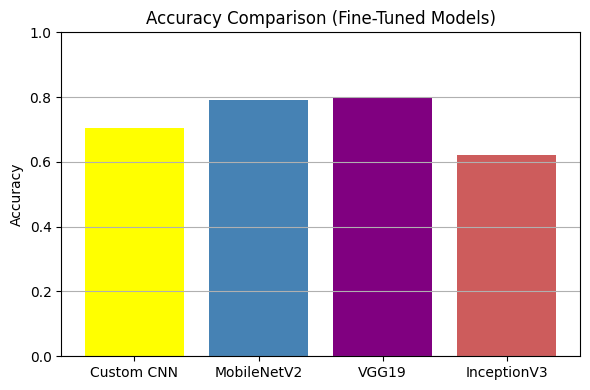

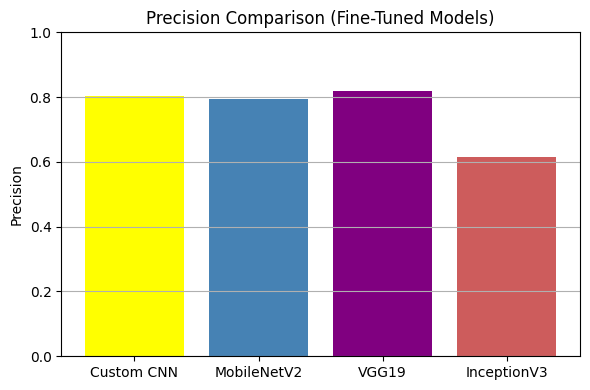

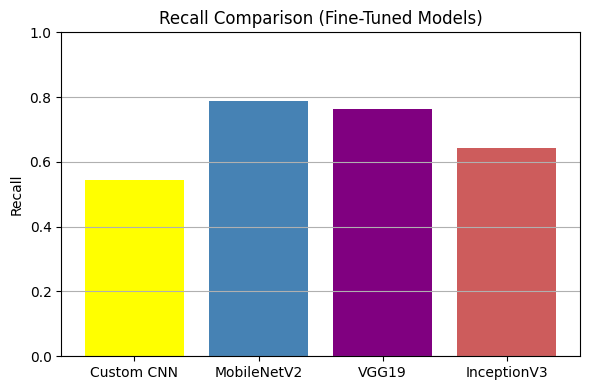

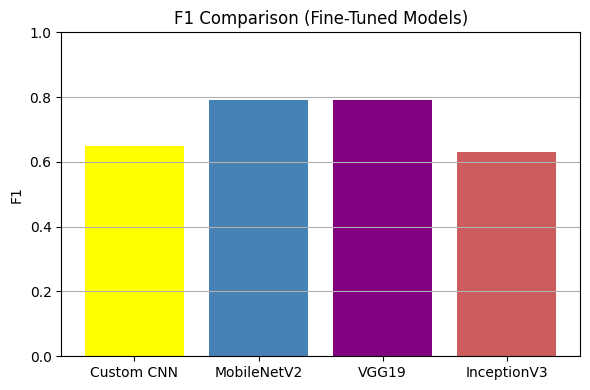

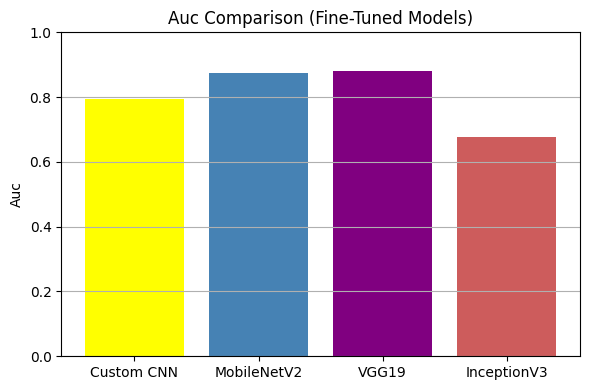

In [225]:
plot_finetuned_metrics(fine_tune_results)

In [84]:
def save_history(history, model_name, directory="saved_history"):
    os.makedirs(directory, exist_ok=True)
    path = os.path.join(directory, f"{model_name}_history.json")

    with open(path, 'w') as f:
        json.dump(history.history, f)

    print(f"History saved in: {path}")

In [85]:
def load_history(model_name, directory="saved_history"):
    path = os.path.join(directory, f"{model_name}_history.json")

    if not os.path.exists(path):
        raise FileNotFoundError(f"Nessuna history trovata per '{model_name}' in '{directory}'.")

    with open(path, 'r') as f:
        history = json.load(f)

    print(f"History of '{model_name}' succesfully loaded.")
    return history

In [86]:
def plot_saved_history(history_dict, model_name="Model"):

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history_dict['loss'], label='Train Loss')
    plt.plot(history_dict['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history_dict['accuracy'], label='Train Acc')
    plt.plot(history_dict['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [87]:
def plot_training_curves(history, title="Training Curves"):
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

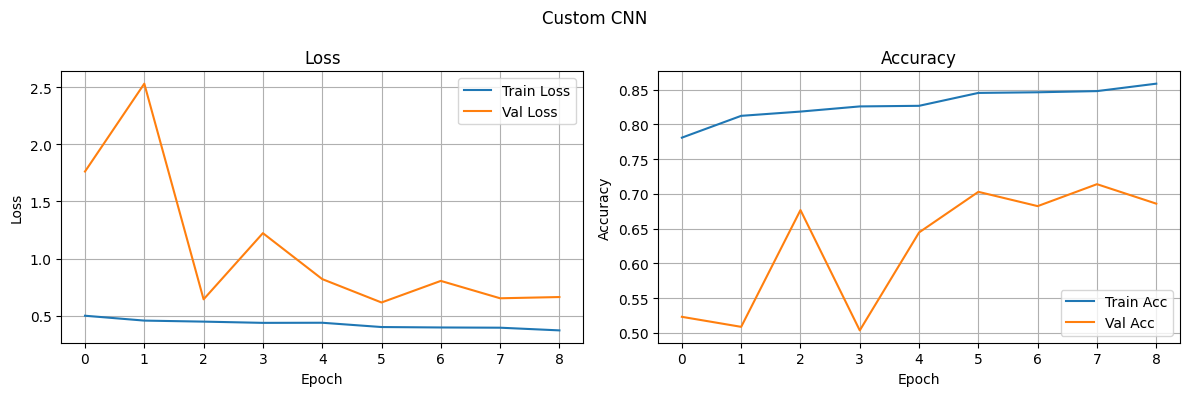

In [226]:
plot_training_curves(history_cnn, "Custom CNN")

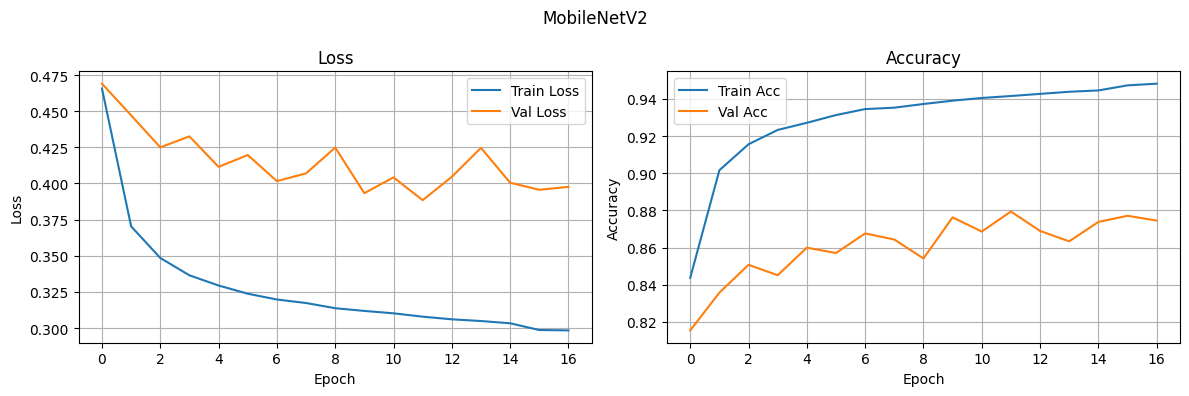

In [228]:
plot_training_curves(history_light, "MobileNetV2")

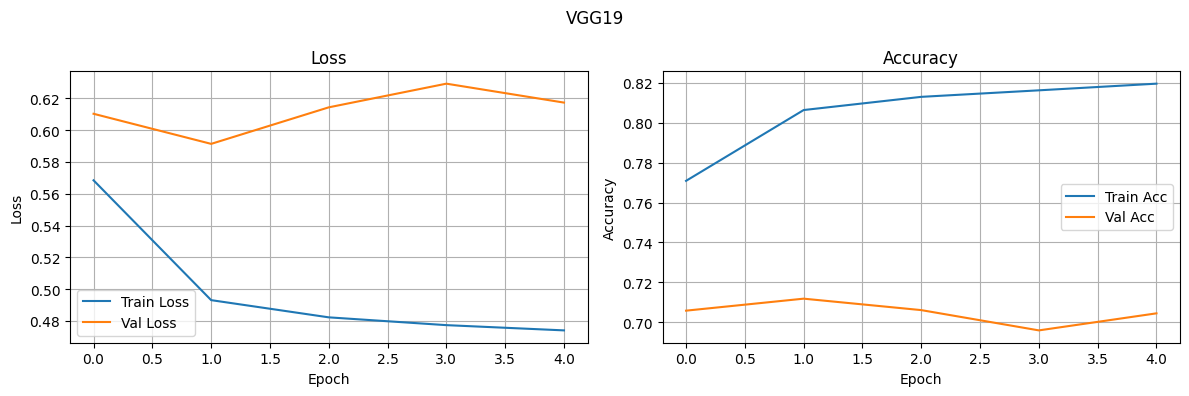

In [123]:
plot_training_curves(history_vgg, "VGG19")

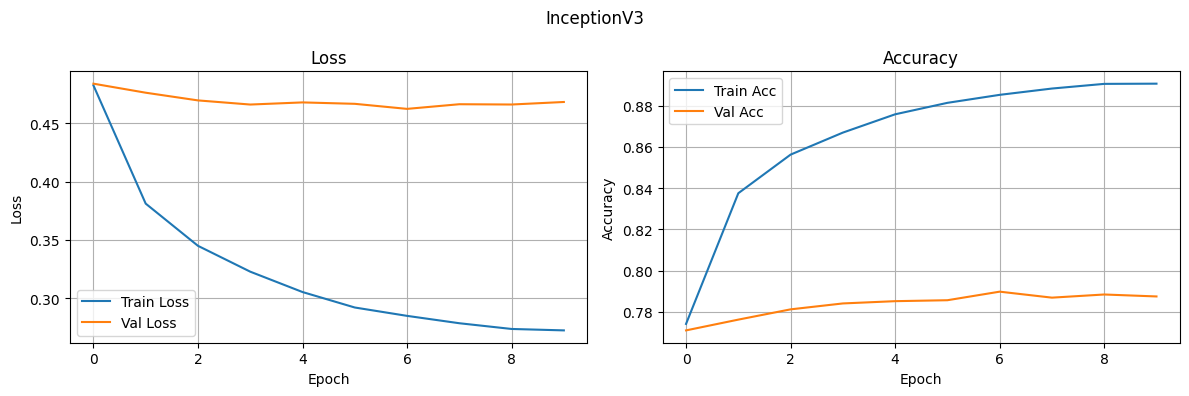

In [229]:
plot_training_curves(history_inception, "InceptionV3")

In [95]:
def evaluate_model(model, val_ds, label=""):
    y_true, y_pred = [], []

    for x_batch, y_batch in val_ds.take(20):
        preds = model.predict(x_batch)
        y_pred.extend((preds > 0.5).astype(int).flatten())
        y_true.extend(y_batch.numpy().flatten())

    print(f"\n Results for {label}:")
    print(classification_report(y_true, y_pred, digits=4))
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix: {label}")
    plt.show()

2/2 [==============================] - 0s 8ms/step

 Results for Custom CNN:
              precision    recall  f1-score   support

         0.0     0.6481    0.8764    0.7452       639
         1.0     0.8101    0.5257    0.6377       641

    accuracy                         0.7008      1280
   macro avg     0.7291    0.7011    0.6914      1280
weighted avg     0.7292    0.7008    0.6913      1280



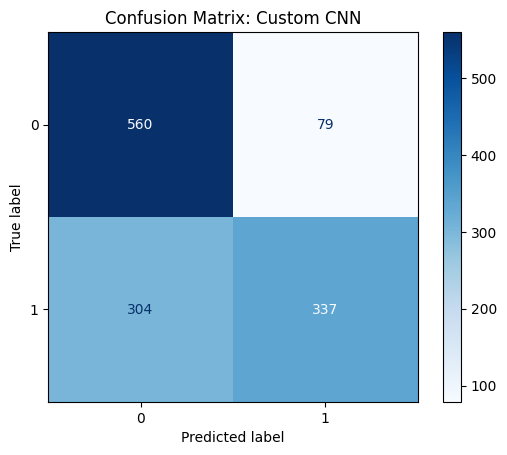

In [230]:
evaluate_model(custom_cnn, val_ds, label="Custom CNN")

2/2 [==============================] - 0s 52ms/step

 Results for MobileNetV2:
              precision    recall  f1-score   support

         0.0     0.8855    0.8609    0.8730       647
         1.0     0.8618    0.8863    0.8738       633

    accuracy                         0.8734      1280
   macro avg     0.8736    0.8736    0.8734      1280
weighted avg     0.8738    0.8734    0.8734      1280



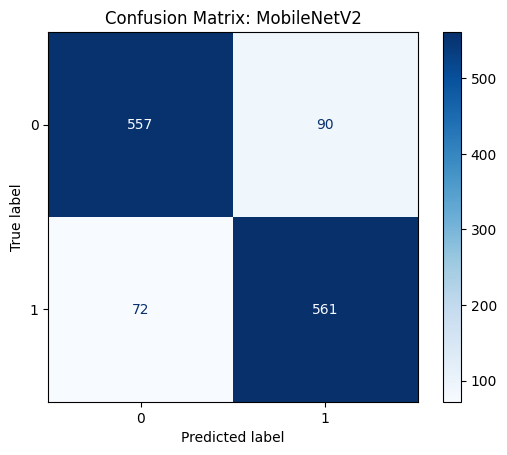

In [189]:
evaluate_model(mobilenet2_light, val_ds, label="MobileNetV2")

2/2 [==============================] - 1s 442ms/step

 Results for VGG19:
              precision    recall  f1-score   support

         0.0     0.6333    0.9605    0.7633       633
         1.0     0.9219    0.4560    0.6101       647

    accuracy                         0.7055      1280
   macro avg     0.7776    0.7082    0.6867      1280
weighted avg     0.7792    0.7055    0.6859      1280



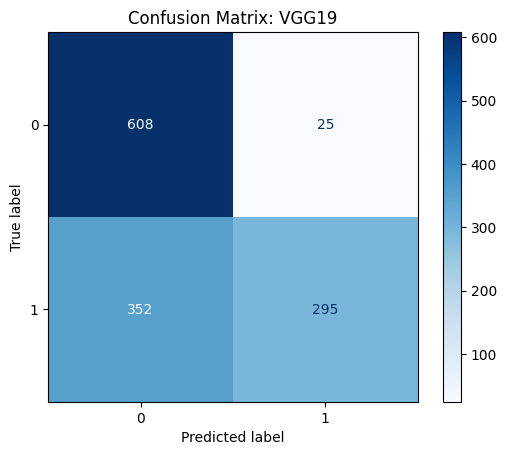

In [190]:
evaluate_model(vgg_model, val_ds, label="VGG19")

2/2 [==============================] - 1s 403ms/step

 Results for InceptionV3:
              precision    recall  f1-score   support

           0     0.7590    0.7900    0.7742       638
           1     0.7825    0.7508    0.7663       642

    accuracy                         0.7703      1280
   macro avg     0.7708    0.7704    0.7702      1280
weighted avg     0.7708    0.7703    0.7702      1280



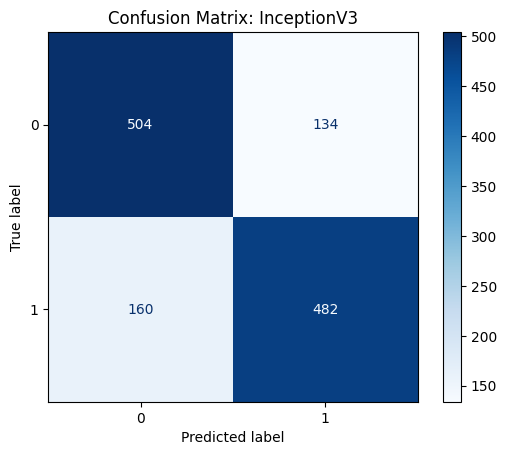

In [192]:
evaluate_model(inception, val_ds_inc, label="InceptionV3")

In [231]:
# Predizioni di probabilità
probs_cnn = custom_cnn.predict(x_test_resized).flatten()
probs_mob = mobilenet2_light.predict(x_test_resized).flatten()
probs_inc = inception.predict(x_test).flatten()
probs_vgg = vgg_model.predict(x_test_resized).flatten()

# Predizioni binarie
preds_cnn = (probs_cnn > 0.5).astype(int)
preds_mob = (probs_mob > 0.5).astype(int)
preds_inc = (probs_inc > 0.5).astype(int)
preds_vgg = (probs_vgg > 0.5).astype(int)

# Confronto diretto
comparison_df = pd.DataFrame({
    'True Label': y_test,
    'Custom CNN_Pred': preds_cnn,
    'MobileNet_Pred': preds_mob,
    'VGG_Pred': preds_vgg,
    'Inception_Pred': preds_inc,
    'Custom CNN_Prob': probs_cnn,
    'MobileNet_Prob': probs_mob,
    'VGG_Prob': probs_vgg,
    'Inception_Prob': probs_inc
})

1024/1024 [==============================] - 438s 427ms/step


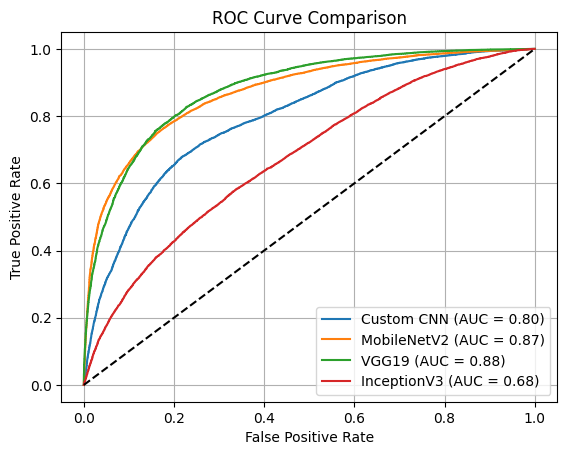

In [232]:
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, probs_cnn)
fpr_mob, tpr_mob, _ = roc_curve(y_test, probs_mob)
fpr_inc, tpr_inc, _ = roc_curve(y_test, probs_inc)
fpr_vgg, tpr_vgg, _ = roc_curve(y_test, probs_vgg)

plt.plot(fpr_cnn, tpr_cnn, label=f"Custom CNN (AUC = {auc(fpr_cnn, tpr_cnn):.2f})")
plt.plot(fpr_mob, tpr_mob, label=f"MobileNetV2 (AUC = {auc(fpr_mob, tpr_mob):.2f})")
plt.plot(fpr_vgg, tpr_vgg, label=f"VGG19 (AUC = {auc(fpr_vgg, tpr_vgg):.2f})")
plt.plot(fpr_inc, tpr_inc, label=f"InceptionV3 (AUC = {auc(fpr_inc, tpr_inc):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

# Explainability (LIME)

To gain visual insights into what each fine-tuned network “looks at” when deciding tumor vs. normal, we applied LIME to a representative test patch (n=10). The yellow contours enclose the super-pixels that most strongly contributed to the model’s tumor prediction.

1. **Custom CNN**

   * Attends to relatively large and dense nuclear regions, but with some noisy boundaries and less spatial precision.
   * Despite its simpler architecture, the model captures coarse spatial cues, especially for normal tissue. However, this may explain its **high precision (0.80)** but **lower recall (0.54)**—it misses subtle or ambiguous tumor regions.

2. **MobileNetV2**

   * Focuses on compact clusters of dark nuclei and small glandular structures, reflecting fine adaptation of early convolutional layers to H\&E staining.
   * Highlights dense, irregular nuclei—hallmarks of tumor—leading to balanced precision/recall and robust AUC.

3. **InceptionV3**

   * Highlights broader, irregular tissue patches rather than detailed nuclei.
   * Multi‐scale feature extractors may blend background stroma with meaningful structures, reducing discrimination—mirroring its lower AUC and accuracy.

4. **VGG19**

   * Attends to extended areas of clustered nuclei with strong contrast and boundary definition.
   * Its fixed filters excel at detecting structured tumor nests, yielding **high precision (0.82)** and **best AUC (0.88)**.

**Key takeaway:**
LIME confirms that **VGG19** and **MobileNetV2** focus on biologically relevant nuclear patterns critical for tumor identification, while **InceptionV3** and the **Custom CNN** produce more diffuse explanations—consistent with their lower sensitivity and recall.

1/1 [==============================] - 0s 12ms/step
Predicted label: 1 (Tumor)
True label    : 1 (Tumor)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 10/1000 [00:00<00:11, 88.98it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 20/1000 [00:00<00:10, 89.27it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 30/1000 [00:00<00:11, 87.14it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 41/1000 [00:00<00:10, 95.05it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 51/1000 [00:00<00:10, 92.65it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 63/1000 [00:00<00:09, 101.05it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 74/1000 [00:00<00:08, 103.28it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 88/1000 [00:00<00:07, 114.33it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 100/1000 [00:01<00:09, 93.18it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 120/1000 [00:01<00:08, 100.97it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 140/1000 [00:01<00:08, 102.26it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 159/1000 [00:01<00:06, 121.19it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 173/1000 [00:01<00:07, 111.48it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 190/1000 [00:01<00:07, 109.76it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 210/1000 [00:01<00:06, 112.88it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▎       | 225/1000 [00:02<00:06, 120.62it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 240/1000 [00:02<00:06, 112.18it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 260/1000 [00:02<00:06, 118.14it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 280/1000 [00:02<00:05, 122.36it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 300/1000 [00:02<00:05, 122.13it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 320/1000 [00:02<00:05, 127.57it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 340/1000 [00:03<00:05, 131.27it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 360/1000 [00:03<00:04, 137.62it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 380/1000 [00:03<00:04, 140.23it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 400/1000 [00:03<00:04, 141.39it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 420/1000 [00:03<00:04, 144.11it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 440/1000 [00:03<00:03, 148.39it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 460/1000 [00:03<00:03, 138.92it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 480/1000 [00:03<00:03, 137.94it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 500/1000 [00:04<00:03, 133.17it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 520/1000 [00:04<00:03, 135.40it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 540/1000 [00:04<00:03, 138.49it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 560/1000 [00:04<00:03, 141.00it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 580/1000 [00:04<00:02, 140.23it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 600/1000 [00:04<00:02, 140.85it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 620/1000 [00:04<00:02, 142.93it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 640/1000 [00:05<00:02, 141.75it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 660/1000 [00:05<00:02, 133.51it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 680/1000 [00:05<00:02, 135.32it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 700/1000 [00:05<00:02, 136.72it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 720/1000 [00:05<00:02, 138.66it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▎  | 736/1000 [00:05<00:01, 143.46it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 751/1000 [00:05<00:01, 135.10it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 770/1000 [00:06<00:01, 136.35it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 790/1000 [00:06<00:01, 144.97it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 810/1000 [00:06<00:01, 146.70it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 830/1000 [00:06<00:01, 144.47it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 850/1000 [00:06<00:01, 149.62it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 870/1000 [00:06<00:00, 152.63it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 890/1000 [00:06<00:00, 150.62it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 910/1000 [00:07<00:00, 147.11it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 930/1000 [00:07<00:00, 148.31it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 950/1000 [00:07<00:00, 151.76it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 970/1000 [00:07<00:00, 151.36it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 990/1000 [00:07<00:00, 148.33it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 1000/1000 [00:07<00:00, 131.57it/s]


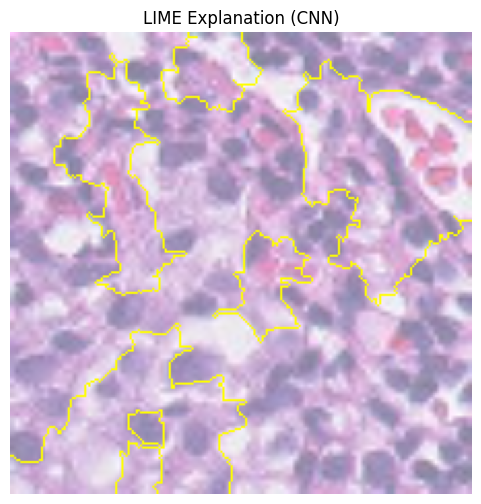

In [264]:
def transform_img_fn(x_array):
    return x_array.astype('double')

n_image = 10  
img = x_test[n_image].numpy()  
img_exp = np.expand_dims(img, axis=0)  

pred_probs = custom_cnn.predict(img_exp)[0][0]
pred_label = int(pred_probs > 0.5)
true_label = y_test[n_image]

print(f"Predicted label: {pred_label} ({'Tumor' if pred_label else 'Normal'})")
print(f"True label    : {true_label} ({'Tumor' if true_label else 'Normal'})")

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image=img.astype('double'),
    classifier_fn=lambda x: custom_cnn.predict(x),
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)

plt.figure(figsize=(6, 6))
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title("LIME Explanation (CNN)")
plt.axis('off')
plt.show()

1/1 [==============================] - 1s 563ms/step
Predicted label: 1 (Tumor)
True label    : 1 (Tumor)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 125ms/step


  1%|          | 10/1000 [00:00<00:16, 58.66it/s]

1/1 [==============================] - 0s 84ms/step


  2%|▏         | 20/1000 [00:00<00:14, 68.73it/s]

1/1 [==============================] - 0s 79ms/step


  3%|▎         | 30/1000 [00:00<00:13, 73.65it/s]

1/1 [==============================] - 0s 78ms/step


  4%|▍         | 40/1000 [00:00<00:12, 77.25it/s]

1/1 [==============================] - 0s 81ms/step


  5%|▌         | 50/1000 [00:00<00:12, 77.42it/s]

1/1 [==============================] - 0s 78ms/step


  6%|▌         | 60/1000 [00:00<00:11, 78.94it/s]

1/1 [==============================] - 0s 79ms/step


  7%|▋         | 70/1000 [00:00<00:11, 79.78it/s]

1/1 [==============================] - 0s 91ms/step


  8%|▊         | 80/1000 [00:01<00:11, 77.32it/s]

1/1 [==============================] - 0s 92ms/step


  9%|▉         | 90/1000 [00:01<00:11, 76.36it/s]

1/1 [==============================] - 0s 86ms/step


 10%|█         | 100/1000 [00:01<00:11, 76.38it/s]

1/1 [==============================] - 0s 91ms/step


 11%|█         | 110/1000 [00:01<00:11, 75.77it/s]

1/1 [==============================] - 0s 80ms/step


 12%|█▏        | 120/1000 [00:01<00:11, 77.37it/s]

1/1 [==============================] - 0s 83ms/step


 13%|█▎        | 130/1000 [00:01<00:11, 78.00it/s]

1/1 [==============================] - 0s 79ms/step


 14%|█▍        | 140/1000 [00:01<00:10, 79.22it/s]

1/1 [==============================] - 0s 79ms/step


 15%|█▌        | 150/1000 [00:01<00:10, 80.16it/s]

1/1 [==============================] - 0s 85ms/step


 16%|█▌        | 160/1000 [00:02<00:10, 78.75it/s]

1/1 [==============================] - 0s 80ms/step


 17%|█▋        | 170/1000 [00:02<00:10, 78.94it/s]

1/1 [==============================] - 0s 79ms/step


 18%|█▊        | 180/1000 [00:02<00:10, 79.73it/s]

1/1 [==============================] - 0s 98ms/step


 19%|█▉        | 190/1000 [00:02<00:10, 76.25it/s]

1/1 [==============================] - 0s 108ms/step


 20%|██        | 200/1000 [00:02<00:10, 72.74it/s]

1/1 [==============================] - 0s 80ms/step


 21%|██        | 210/1000 [00:02<00:10, 75.90it/s]

1/1 [==============================] - 0s 83ms/step


 22%|██▏       | 220/1000 [00:02<00:09, 78.04it/s]

1/1 [==============================] - 0s 82ms/step


 23%|██▎       | 230/1000 [00:02<00:09, 79.07it/s]

1/1 [==============================] - 0s 88ms/step


 24%|██▍       | 240/1000 [00:03<00:09, 78.69it/s]

1/1 [==============================] - 0s 86ms/step


 25%|██▌       | 250/1000 [00:03<00:09, 78.38it/s]

1/1 [==============================] - 0s 81ms/step


 26%|██▌       | 260/1000 [00:03<00:09, 79.48it/s]

1/1 [==============================] - 0s 81ms/step


 27%|██▋       | 270/1000 [00:03<00:09, 79.76it/s]

1/1 [==============================] - 0s 88ms/step


 28%|██▊       | 280/1000 [00:03<00:09, 79.67it/s]

1/1 [==============================] - 0s 114ms/step


 29%|██▉       | 290/1000 [00:03<00:09, 74.17it/s]

1/1 [==============================] - 0s 83ms/step


 30%|███       | 300/1000 [00:03<00:09, 75.29it/s]

1/1 [==============================] - 0s 83ms/step


 31%|███       | 310/1000 [00:04<00:08, 77.15it/s]

1/1 [==============================] - 0s 91ms/step


 32%|███▏      | 320/1000 [00:04<00:08, 76.78it/s]

1/1 [==============================] - 0s 84ms/step


 33%|███▎      | 330/1000 [00:04<00:08, 77.02it/s]

1/1 [==============================] - 0s 93ms/step


 34%|███▍      | 340/1000 [00:04<00:08, 76.61it/s]

1/1 [==============================] - 0s 87ms/step


 35%|███▌      | 350/1000 [00:04<00:08, 76.82it/s]

1/1 [==============================] - 0s 78ms/step


 36%|███▌      | 360/1000 [00:04<00:08, 79.11it/s]

1/1 [==============================] - 0s 82ms/step


 37%|███▋      | 370/1000 [00:04<00:07, 80.46it/s]

1/1 [==============================] - 0s 78ms/step


 38%|███▊      | 380/1000 [00:04<00:07, 81.39it/s]

1/1 [==============================] - 0s 78ms/step


 39%|███▉      | 390/1000 [00:05<00:07, 83.24it/s]

1/1 [==============================] - 0s 75ms/step


 40%|████      | 400/1000 [00:05<00:07, 81.10it/s]

1/1 [==============================] - 0s 85ms/step


 41%|████      | 410/1000 [00:05<00:07, 80.87it/s]

1/1 [==============================] - 0s 88ms/step


 42%|████▏     | 420/1000 [00:05<00:07, 79.67it/s]

1/1 [==============================] - 0s 78ms/step


 43%|████▎     | 430/1000 [00:05<00:07, 81.43it/s]

1/1 [==============================] - 0s 79ms/step


 44%|████▍     | 440/1000 [00:05<00:06, 82.92it/s]

1/1 [==============================] - 0s 80ms/step


 45%|████▌     | 450/1000 [00:05<00:06, 83.07it/s]

1/1 [==============================] - 0s 83ms/step


 46%|████▌     | 460/1000 [00:05<00:06, 82.60it/s]

1/1 [==============================] - 0s 92ms/step


 47%|████▋     | 470/1000 [00:06<00:06, 80.04it/s]

1/1 [==============================] - 0s 83ms/step


 48%|████▊     | 480/1000 [00:06<00:06, 80.29it/s]

1/1 [==============================] - 0s 80ms/step


 49%|████▉     | 490/1000 [00:06<00:06, 81.19it/s]

1/1 [==============================] - 0s 80ms/step


 50%|█████     | 500/1000 [00:06<00:06, 81.63it/s]

1/1 [==============================] - 0s 80ms/step


 51%|█████     | 510/1000 [00:06<00:05, 82.02it/s]

1/1 [==============================] - 0s 79ms/step


 52%|█████▏    | 520/1000 [00:06<00:05, 82.94it/s]

1/1 [==============================] - 0s 78ms/step


 53%|█████▎    | 530/1000 [00:06<00:05, 84.33it/s]

1/1 [==============================] - 0s 81ms/step


 54%|█████▍    | 540/1000 [00:06<00:05, 84.11it/s]

1/1 [==============================] - 0s 82ms/step


 55%|█████▌    | 550/1000 [00:06<00:05, 83.77it/s]

1/1 [==============================] - 0s 111ms/step


 56%|█████▌    | 560/1000 [00:07<00:05, 77.53it/s]

1/1 [==============================] - 0s 119ms/step


 57%|█████▋    | 570/1000 [00:07<00:06, 70.85it/s]

1/1 [==============================] - 0s 117ms/step


 58%|█████▊    | 580/1000 [00:07<00:06, 67.93it/s]

1/1 [==============================] - 0s 85ms/step


 59%|█████▉    | 590/1000 [00:07<00:05, 70.25it/s]

1/1 [==============================] - 0s 87ms/step


 60%|██████    | 600/1000 [00:07<00:05, 72.55it/s]

1/1 [==============================] - 0s 87ms/step


 61%|██████    | 610/1000 [00:07<00:05, 73.96it/s]

1/1 [==============================] - 0s 86ms/step


 62%|██████▏   | 620/1000 [00:07<00:05, 75.66it/s]

1/1 [==============================] - 0s 81ms/step


 63%|██████▎   | 630/1000 [00:08<00:04, 77.89it/s]

1/1 [==============================] - 0s 89ms/step


 64%|██████▍   | 640/1000 [00:08<00:04, 77.49it/s]

1/1 [==============================] - 0s 89ms/step


 65%|██████▌   | 650/1000 [00:08<00:04, 76.85it/s]

1/1 [==============================] - 0s 83ms/step


 66%|██████▌   | 660/1000 [00:08<00:04, 78.54it/s]

1/1 [==============================] - 0s 86ms/step


 67%|██████▋   | 670/1000 [00:08<00:04, 78.20it/s]

1/1 [==============================] - 0s 84ms/step


 68%|██████▊   | 680/1000 [00:08<00:04, 76.13it/s]

1/1 [==============================] - 0s 79ms/step


 69%|██████▉   | 690/1000 [00:08<00:03, 78.48it/s]

1/1 [==============================] - 0s 78ms/step


 70%|███████   | 700/1000 [00:08<00:03, 80.45it/s]

1/1 [==============================] - 0s 78ms/step


 71%|███████   | 710/1000 [00:09<00:03, 82.26it/s]

1/1 [==============================] - 0s 79ms/step


 72%|███████▏  | 720/1000 [00:09<00:03, 83.13it/s]

1/1 [==============================] - 0s 82ms/step


 73%|███████▎  | 730/1000 [00:09<00:03, 82.35it/s]

1/1 [==============================] - 0s 77ms/step


 74%|███████▍  | 740/1000 [00:09<00:03, 84.02it/s]

1/1 [==============================] - 0s 78ms/step


 75%|███████▌  | 750/1000 [00:09<00:02, 83.91it/s]

1/1 [==============================] - 0s 83ms/step


 76%|███████▌  | 760/1000 [00:09<00:02, 83.82it/s]

1/1 [==============================] - 0s 87ms/step


 77%|███████▋  | 770/1000 [00:09<00:02, 81.10it/s]

1/1 [==============================] - 0s 80ms/step


 78%|███████▊  | 780/1000 [00:09<00:02, 80.89it/s]

1/1 [==============================] - 0s 81ms/step


 79%|███████▉  | 790/1000 [00:10<00:02, 81.96it/s]

1/1 [==============================] - 0s 86ms/step


 80%|████████  | 800/1000 [00:10<00:02, 81.17it/s]

1/1 [==============================] - 0s 87ms/step


 81%|████████  | 810/1000 [00:10<00:02, 79.96it/s]

1/1 [==============================] - 0s 81ms/step


 82%|████████▏ | 820/1000 [00:10<00:02, 80.72it/s]

1/1 [==============================] - 0s 77ms/step


 83%|████████▎ | 830/1000 [00:10<00:02, 82.41it/s]

1/1 [==============================] - 0s 91ms/step


 84%|████████▍ | 840/1000 [00:10<00:01, 80.91it/s]

1/1 [==============================] - 0s 85ms/step


 85%|████████▌ | 850/1000 [00:10<00:01, 80.12it/s]

1/1 [==============================] - 0s 81ms/step


 86%|████████▌ | 860/1000 [00:10<00:01, 80.29it/s]

1/1 [==============================] - 0s 78ms/step


 87%|████████▋ | 870/1000 [00:11<00:01, 82.26it/s]

1/1 [==============================] - 0s 77ms/step


 88%|████████▊ | 880/1000 [00:11<00:01, 83.75it/s]

1/1 [==============================] - 0s 82ms/step


 89%|████████▉ | 890/1000 [00:11<00:01, 83.91it/s]

1/1 [==============================] - 0s 86ms/step


 90%|█████████ | 900/1000 [00:11<00:01, 81.78it/s]

1/1 [==============================] - 0s 85ms/step


 91%|█████████ | 910/1000 [00:11<00:01, 80.71it/s]

1/1 [==============================] - 0s 84ms/step


 92%|█████████▏| 920/1000 [00:11<00:00, 80.13it/s]

1/1 [==============================] - 0s 79ms/step


 93%|█████████▎| 930/1000 [00:11<00:00, 80.87it/s]

1/1 [==============================] - 0s 86ms/step


 94%|█████████▍| 940/1000 [00:11<00:00, 80.27it/s]

1/1 [==============================] - 0s 88ms/step


 95%|█████████▌| 950/1000 [00:12<00:00, 78.93it/s]

1/1 [==============================] - 0s 86ms/step


 96%|█████████▌| 960/1000 [00:12<00:00, 78.86it/s]

1/1 [==============================] - 0s 83ms/step


 97%|█████████▋| 970/1000 [00:12<00:00, 79.79it/s]

1/1 [==============================] - 0s 97ms/step


 98%|█████████▊| 980/1000 [00:12<00:00, 76.56it/s]

1/1 [==============================] - 0s 92ms/step


 99%|█████████▉| 990/1000 [00:12<00:00, 75.03it/s]

1/1 [==============================] - 0s 79ms/step


100%|██████████| 1000/1000 [00:12<00:00, 78.80it/s]


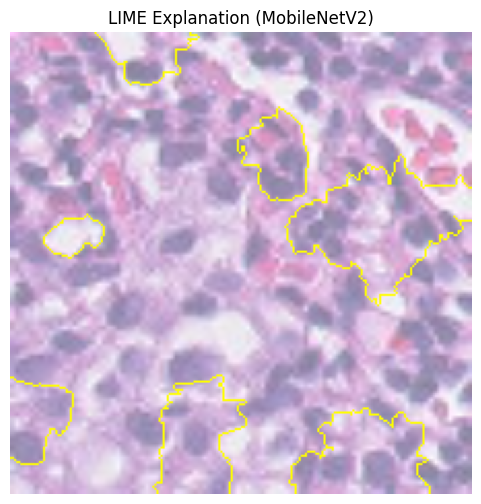

In [265]:
def transform_img_fn(x_array):
    return x_array.astype('double')

n_image = 10  
img = x_test[n_image].numpy()  
img_exp = np.expand_dims(img, axis=0)  

pred_probs = mobilenet2_light.predict(img_exp)[0][0]
pred_label = int(pred_probs > 0.5)
true_label = y_test[n_image]

print(f"Predicted label: {pred_label} ({'Tumor' if pred_label else 'Normal'})")
print(f"True label    : {true_label} ({'Tumor' if true_label else 'Normal'})")

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image=img.astype('double'),
    classifier_fn=lambda x: mobilenet2_light.predict(x),
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)

plt.figure(figsize=(6, 6))
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title("LIME Explanation (MobileNetV2)")
plt.axis('off')
plt.show()

1/1 [==============================] - 1s 887ms/step
Predicted label: 1 (Tumor)
True label    : 1 (Tumor)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 164ms/step


  1%|          | 10/1000 [00:00<00:21, 45.47it/s]

1/1 [==============================] - 0s 146ms/step


  2%|▏         | 20/1000 [00:00<00:20, 47.74it/s]

1/1 [==============================] - 0s 138ms/step


  3%|▎         | 30/1000 [00:00<00:18, 51.09it/s]

1/1 [==============================] - 0s 141ms/step


  4%|▍         | 40/1000 [00:00<00:18, 52.30it/s]

1/1 [==============================] - 0s 132ms/step


  5%|▌         | 50/1000 [00:00<00:17, 54.04it/s]

1/1 [==============================] - 0s 152ms/step


  6%|▌         | 60/1000 [00:01<00:17, 53.22it/s]

1/1 [==============================] - 0s 134ms/step


  7%|▋         | 70/1000 [00:01<00:17, 54.26it/s]

1/1 [==============================] - 0s 141ms/step


  8%|▊         | 80/1000 [00:01<00:16, 54.45it/s]

1/1 [==============================] - 0s 134ms/step


  9%|▉         | 90/1000 [00:01<00:16, 55.02it/s]

1/1 [==============================] - 0s 137ms/step


 10%|█         | 100/1000 [00:01<00:16, 55.34it/s]

1/1 [==============================] - 0s 138ms/step


 11%|█         | 110/1000 [00:02<00:16, 54.69it/s]

1/1 [==============================] - 0s 143ms/step


 12%|█▏        | 120/1000 [00:02<00:16, 54.30it/s]

1/1 [==============================] - 0s 149ms/step


 13%|█▎        | 130/1000 [00:02<00:16, 53.72it/s]

1/1 [==============================] - 0s 186ms/step


 14%|█▍        | 140/1000 [00:02<00:17, 48.86it/s]

1/1 [==============================] - 0s 148ms/step


 15%|█▌        | 150/1000 [00:02<00:16, 50.18it/s]

1/1 [==============================] - 0s 142ms/step


 16%|█▌        | 160/1000 [00:03<00:16, 51.24it/s]

1/1 [==============================] - 0s 131ms/step


 17%|█▋        | 170/1000 [00:03<00:15, 53.40it/s]

1/1 [==============================] - 0s 145ms/step


 18%|█▊        | 180/1000 [00:03<00:15, 53.56it/s]

1/1 [==============================] - 0s 141ms/step


 19%|█▉        | 190/1000 [00:03<00:15, 53.65it/s]

1/1 [==============================] - 0s 241ms/step


 20%|██        | 200/1000 [00:03<00:17, 46.55it/s]

1/1 [==============================] - 0s 144ms/step


 21%|██        | 210/1000 [00:04<00:16, 48.65it/s]

1/1 [==============================] - 0s 144ms/step


 22%|██▏       | 220/1000 [00:04<00:15, 50.32it/s]

1/1 [==============================] - 0s 143ms/step


 23%|██▎       | 230/1000 [00:04<00:14, 51.56it/s]

1/1 [==============================] - 0s 136ms/step


 24%|██▍       | 240/1000 [00:04<00:14, 53.18it/s]

1/1 [==============================] - 0s 164ms/step


 25%|██▌       | 250/1000 [00:04<00:14, 51.99it/s]

1/1 [==============================] - 0s 134ms/step


 26%|██▌       | 260/1000 [00:05<00:14, 50.89it/s]

1/1 [==============================] - 0s 133ms/step


 27%|██▋       | 270/1000 [00:05<00:13, 52.72it/s]

1/1 [==============================] - 0s 141ms/step


 28%|██▊       | 280/1000 [00:05<00:13, 53.72it/s]

1/1 [==============================] - 0s 136ms/step


 29%|██▉       | 290/1000 [00:05<00:12, 54.70it/s]

1/1 [==============================] - 0s 133ms/step


 30%|███       | 300/1000 [00:05<00:12, 55.60it/s]

1/1 [==============================] - 0s 131ms/step


 31%|███       | 310/1000 [00:05<00:12, 56.69it/s]

1/1 [==============================] - 0s 145ms/step


 32%|███▏      | 320/1000 [00:06<00:12, 56.25it/s]

1/1 [==============================] - 0s 134ms/step


 33%|███▎      | 330/1000 [00:06<00:11, 56.67it/s]

1/1 [==============================] - 0s 134ms/step


 34%|███▍      | 340/1000 [00:06<00:11, 57.09it/s]

1/1 [==============================] - 0s 136ms/step


 35%|███▌      | 350/1000 [00:06<00:11, 57.35it/s]

1/1 [==============================] - 0s 133ms/step


 36%|███▌      | 360/1000 [00:06<00:11, 57.80it/s]

1/1 [==============================] - 0s 131ms/step


 37%|███▋      | 370/1000 [00:06<00:10, 58.26it/s]

1/1 [==============================] - 0s 134ms/step


 38%|███▊      | 380/1000 [00:07<00:10, 57.66it/s]

1/1 [==============================] - 0s 144ms/step


 39%|███▉      | 390/1000 [00:07<00:10, 56.66it/s]

1/1 [==============================] - 0s 133ms/step


 40%|████      | 400/1000 [00:07<00:10, 57.25it/s]

1/1 [==============================] - 0s 151ms/step


 41%|████      | 410/1000 [00:07<00:10, 55.74it/s]

1/1 [==============================] - 0s 136ms/step


 42%|████▏     | 420/1000 [00:07<00:10, 55.90it/s]

1/1 [==============================] - 0s 143ms/step


 43%|████▎     | 430/1000 [00:07<00:10, 55.69it/s]

1/1 [==============================] - 0s 144ms/step


 44%|████▍     | 440/1000 [00:08<00:10, 55.39it/s]

1/1 [==============================] - 0s 139ms/step


 45%|████▌     | 450/1000 [00:08<00:09, 55.75it/s]

1/1 [==============================] - 0s 151ms/step


 46%|████▌     | 460/1000 [00:08<00:09, 54.55it/s]

1/1 [==============================] - 0s 148ms/step


 47%|████▋     | 470/1000 [00:08<00:09, 53.93it/s]

1/1 [==============================] - 0s 188ms/step


 48%|████▊     | 480/1000 [00:08<00:10, 49.94it/s]

1/1 [==============================] - 0s 176ms/step


 49%|████▉     | 490/1000 [00:09<00:10, 48.56it/s]

1/1 [==============================] - 0s 142ms/step


 50%|█████     | 500/1000 [00:09<00:10, 49.83it/s]

1/1 [==============================] - 0s 142ms/step


 51%|█████     | 510/1000 [00:09<00:09, 51.22it/s]

1/1 [==============================] - 0s 145ms/step


 52%|█████▏    | 520/1000 [00:09<00:09, 51.23it/s]

1/1 [==============================] - 0s 153ms/step


 53%|█████▎    | 530/1000 [00:09<00:09, 51.31it/s]

1/1 [==============================] - 0s 141ms/step


 54%|█████▍    | 540/1000 [00:10<00:08, 52.18it/s]

1/1 [==============================] - 0s 152ms/step


 55%|█████▌    | 550/1000 [00:10<00:08, 51.98it/s]

1/1 [==============================] - 0s 138ms/step


 56%|█████▌    | 560/1000 [00:10<00:08, 52.96it/s]

1/1 [==============================] - 0s 134ms/step


 57%|█████▋    | 570/1000 [00:10<00:08, 53.70it/s]

1/1 [==============================] - 0s 136ms/step


 58%|█████▊    | 580/1000 [00:10<00:07, 54.26it/s]

1/1 [==============================] - 0s 137ms/step


 59%|█████▉    | 590/1000 [00:11<00:07, 54.88it/s]

1/1 [==============================] - 0s 137ms/step


 60%|██████    | 600/1000 [00:11<00:07, 55.05it/s]

1/1 [==============================] - 0s 134ms/step


 61%|██████    | 610/1000 [00:11<00:07, 55.60it/s]

1/1 [==============================] - 0s 135ms/step


 62%|██████▏   | 620/1000 [00:11<00:06, 56.10it/s]

1/1 [==============================] - 0s 133ms/step


 63%|██████▎   | 630/1000 [00:11<00:06, 56.59it/s]

1/1 [==============================] - 0s 145ms/step


 64%|██████▍   | 640/1000 [00:11<00:06, 55.78it/s]

1/1 [==============================] - 0s 156ms/step


 65%|██████▌   | 650/1000 [00:12<00:06, 53.31it/s]

1/1 [==============================] - 0s 156ms/step


 66%|██████▌   | 660/1000 [00:12<00:06, 51.92it/s]

1/1 [==============================] - 0s 138ms/step


 67%|██████▋   | 670/1000 [00:12<00:06, 52.86it/s]

1/1 [==============================] - 0s 136ms/step


 68%|██████▊   | 680/1000 [00:12<00:05, 53.83it/s]

1/1 [==============================] - 0s 139ms/step


 69%|██████▉   | 690/1000 [00:12<00:05, 54.30it/s]

1/1 [==============================] - 0s 135ms/step


 70%|███████   | 700/1000 [00:13<00:05, 55.14it/s]

1/1 [==============================] - 0s 138ms/step


 71%|███████   | 710/1000 [00:13<00:05, 55.26it/s]

1/1 [==============================] - 0s 154ms/step


 72%|███████▏  | 720/1000 [00:13<00:05, 53.99it/s]

1/1 [==============================] - 0s 136ms/step


 73%|███████▎  | 730/1000 [00:13<00:04, 54.47it/s]

1/1 [==============================] - 0s 137ms/step


 74%|███████▍  | 740/1000 [00:13<00:04, 54.65it/s]

1/1 [==============================] - 0s 146ms/step


 75%|███████▌  | 750/1000 [00:13<00:04, 54.29it/s]

1/1 [==============================] - 0s 141ms/step


 76%|███████▌  | 760/1000 [00:14<00:04, 53.93it/s]

1/1 [==============================] - 0s 136ms/step


 77%|███████▋  | 770/1000 [00:14<00:04, 54.66it/s]

1/1 [==============================] - 0s 135ms/step


 78%|███████▊  | 780/1000 [00:14<00:03, 55.40it/s]

1/1 [==============================] - 0s 192ms/step


 79%|███████▉  | 790/1000 [00:14<00:04, 50.45it/s]

1/1 [==============================] - 0s 135ms/step


 80%|████████  | 800/1000 [00:14<00:03, 52.27it/s]

1/1 [==============================] - 0s 137ms/step


 81%|████████  | 810/1000 [00:15<00:03, 52.98it/s]

1/1 [==============================] - 0s 135ms/step


 82%|████████▏ | 820/1000 [00:15<00:03, 54.17it/s]

1/1 [==============================] - 0s 138ms/step


 83%|████████▎ | 830/1000 [00:15<00:03, 54.75it/s]

1/1 [==============================] - 0s 137ms/step


 84%|████████▍ | 840/1000 [00:15<00:02, 55.03it/s]

1/1 [==============================] - 0s 136ms/step


 85%|████████▌ | 850/1000 [00:15<00:02, 55.00it/s]

1/1 [==============================] - 0s 135ms/step


 86%|████████▌ | 860/1000 [00:16<00:02, 55.44it/s]

1/1 [==============================] - 0s 136ms/step


 87%|████████▋ | 870/1000 [00:16<00:02, 55.88it/s]

1/1 [==============================] - 0s 135ms/step


 88%|████████▊ | 880/1000 [00:16<00:02, 56.20it/s]

1/1 [==============================] - 0s 135ms/step


 89%|████████▉ | 890/1000 [00:16<00:01, 56.30it/s]

1/1 [==============================] - 0s 134ms/step


 90%|█████████ | 900/1000 [00:16<00:01, 56.59it/s]

1/1 [==============================] - 0s 153ms/step


 91%|█████████ | 910/1000 [00:16<00:01, 54.90it/s]

1/1 [==============================] - 0s 144ms/step


 92%|█████████▏| 920/1000 [00:17<00:01, 54.45it/s]

1/1 [==============================] - 0s 135ms/step


 93%|█████████▎| 930/1000 [00:17<00:01, 55.17it/s]

1/1 [==============================] - 0s 135ms/step


 94%|█████████▍| 940/1000 [00:17<00:01, 55.59it/s]

1/1 [==============================] - 0s 134ms/step


 95%|█████████▌| 950/1000 [00:17<00:00, 55.90it/s]

1/1 [==============================] - 0s 158ms/step


 96%|█████████▌| 960/1000 [00:17<00:00, 54.23it/s]

1/1 [==============================] - 0s 134ms/step


 97%|█████████▋| 970/1000 [00:17<00:00, 55.07it/s]

1/1 [==============================] - 0s 134ms/step


 98%|█████████▊| 980/1000 [00:18<00:00, 55.86it/s]

1/1 [==============================] - 0s 136ms/step


 99%|█████████▉| 990/1000 [00:18<00:00, 56.03it/s]

1/1 [==============================] - 0s 135ms/step


100%|██████████| 1000/1000 [00:18<00:00, 53.98it/s]


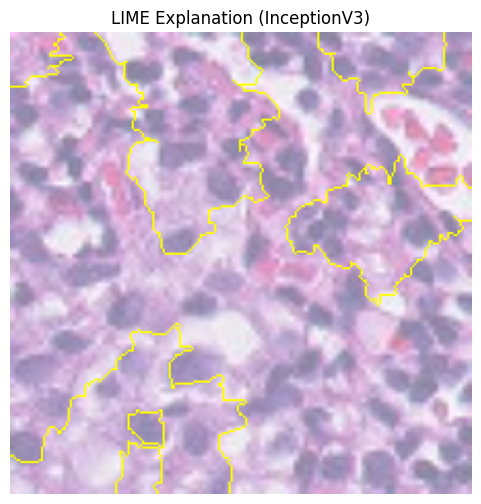

In [161]:
def transform_img_fn(x_array):
    return x_array.astype('double')

n_image = 10  
img = x_test[n_image].numpy()  
img_exp = np.expand_dims(img, axis=0)  

pred_probs = inception.predict(img_exp)[0][0]
pred_label = int(pred_probs > 0.5)
true_label = y_test[n_image]

print(f"Predicted label: {pred_label} ({'Tumor' if pred_label else 'Normal'})")
print(f"True label    : {true_label} ({'Tumor' if true_label else 'Normal'})")

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image=img.astype('double'),
    classifier_fn=lambda x: inception.predict(x),
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)

plt.figure(figsize=(6, 6))
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title("LIME Explanation (InceptionV3)")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 115ms/step
Predicted label: 1 (Tumor)
True label    : 1 (Tumor)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 846ms/step


  1%|          | 10/1000 [00:00<01:27, 11.27it/s]

1/1 [==============================] - 1s 827ms/step


  2%|▏         | 20/1000 [00:01<01:26, 11.39it/s]

1/1 [==============================] - 1s 759ms/step


  3%|▎         | 30/1000 [00:02<01:22, 11.83it/s]

1/1 [==============================] - 1s 759ms/step


  4%|▍         | 40/1000 [00:03<01:19, 12.07it/s]

1/1 [==============================] - 1s 758ms/step


  5%|▌         | 50/1000 [00:04<01:17, 12.23it/s]

1/1 [==============================] - 1s 756ms/step


  6%|▌         | 60/1000 [00:04<01:16, 12.35it/s]

1/1 [==============================] - 1s 753ms/step


  7%|▋         | 70/1000 [00:05<01:14, 12.42it/s]

1/1 [==============================] - 1s 756ms/step


  8%|▊         | 80/1000 [00:06<01:13, 12.45it/s]

1/1 [==============================] - 1s 775ms/step


  9%|▉         | 90/1000 [00:07<01:13, 12.40it/s]

1/1 [==============================] - 1s 757ms/step


 10%|█         | 100/1000 [00:08<01:12, 12.45it/s]

1/1 [==============================] - 1s 765ms/step


 11%|█         | 110/1000 [00:08<01:11, 12.45it/s]

1/1 [==============================] - 1s 754ms/step


 12%|█▏        | 120/1000 [00:09<01:10, 12.50it/s]

1/1 [==============================] - 1s 758ms/step


 13%|█▎        | 130/1000 [00:10<01:09, 12.51it/s]

1/1 [==============================] - 1s 755ms/step


 14%|█▍        | 140/1000 [00:11<01:08, 12.53it/s]

1/1 [==============================] - 1s 809ms/step


 15%|█▌        | 150/1000 [00:12<01:09, 12.27it/s]

1/1 [==============================] - 1s 758ms/step


 16%|█▌        | 160/1000 [00:13<01:08, 12.35it/s]

1/1 [==============================] - 1s 754ms/step


 17%|█▋        | 170/1000 [00:13<01:06, 12.41it/s]

1/1 [==============================] - 1s 753ms/step


 18%|█▊        | 180/1000 [00:14<01:05, 12.47it/s]

1/1 [==============================] - 1s 748ms/step


 19%|█▉        | 190/1000 [00:15<01:04, 12.54it/s]

1/1 [==============================] - 1s 752ms/step


 20%|██        | 200/1000 [00:16<01:03, 12.57it/s]

1/1 [==============================] - 1s 752ms/step


 21%|██        | 210/1000 [00:16<01:02, 12.59it/s]

1/1 [==============================] - 1s 756ms/step


 22%|██▏       | 220/1000 [00:17<01:01, 12.58it/s]

1/1 [==============================] - 1s 773ms/step


 23%|██▎       | 230/1000 [00:18<01:01, 12.49it/s]

1/1 [==============================] - 1s 755ms/step


 24%|██▍       | 240/1000 [00:19<01:00, 12.51it/s]

1/1 [==============================] - 1s 756ms/step


 25%|██▌       | 250/1000 [00:20<00:59, 12.52it/s]

1/1 [==============================] - 1s 750ms/step


 26%|██▌       | 260/1000 [00:20<00:58, 12.55it/s]

1/1 [==============================] - 1s 808ms/step


 27%|██▋       | 270/1000 [00:21<00:59, 12.32it/s]

1/1 [==============================] - 1s 758ms/step


 28%|██▊       | 280/1000 [00:22<00:58, 12.38it/s]

1/1 [==============================] - 1s 755ms/step


 29%|██▉       | 290/1000 [00:23<00:57, 12.44it/s]

1/1 [==============================] - 1s 753ms/step


 30%|███       | 300/1000 [00:24<00:56, 12.49it/s]

1/1 [==============================] - 1s 754ms/step


 31%|███       | 310/1000 [00:24<00:55, 12.53it/s]

1/1 [==============================] - 1s 752ms/step


 32%|███▏      | 320/1000 [00:25<00:54, 12.55it/s]

1/1 [==============================] - 1s 753ms/step


 33%|███▎      | 330/1000 [00:26<00:53, 12.57it/s]

1/1 [==============================] - 1s 759ms/step


 34%|███▍      | 340/1000 [00:27<00:52, 12.56it/s]

1/1 [==============================] - 1s 752ms/step


 35%|███▌      | 350/1000 [00:28<00:51, 12.56it/s]

1/1 [==============================] - 1s 749ms/step


 36%|███▌      | 360/1000 [00:28<00:50, 12.56it/s]

1/1 [==============================] - 1s 776ms/step


 37%|███▋      | 370/1000 [00:29<00:50, 12.47it/s]

1/1 [==============================] - 1s 753ms/step


 38%|███▊      | 380/1000 [00:30<00:49, 12.53it/s]

1/1 [==============================] - 1s 752ms/step


 39%|███▉      | 390/1000 [00:31<00:48, 12.57it/s]

1/1 [==============================] - 1s 813ms/step


 40%|████      | 400/1000 [00:32<00:48, 12.31it/s]

1/1 [==============================] - 1s 754ms/step


 41%|████      | 410/1000 [00:32<00:47, 12.40it/s]

1/1 [==============================] - 1s 753ms/step


 42%|████▏     | 420/1000 [00:33<00:46, 12.47it/s]

1/1 [==============================] - 1s 756ms/step


 43%|████▎     | 430/1000 [00:34<00:45, 12.50it/s]

1/1 [==============================] - 1s 754ms/step


 44%|████▍     | 440/1000 [00:35<00:44, 12.52it/s]

1/1 [==============================] - 1s 752ms/step


 45%|████▌     | 450/1000 [00:36<00:43, 12.55it/s]

1/1 [==============================] - 1s 752ms/step


 46%|████▌     | 460/1000 [00:36<00:42, 12.57it/s]

1/1 [==============================] - 1s 755ms/step


 47%|████▋     | 470/1000 [00:37<00:42, 12.57it/s]

1/1 [==============================] - 1s 754ms/step


 48%|████▊     | 480/1000 [00:38<00:41, 12.58it/s]

1/1 [==============================] - 1s 757ms/step


 49%|████▉     | 490/1000 [00:39<00:40, 12.58it/s]

1/1 [==============================] - 1s 778ms/step


 50%|█████     | 500/1000 [00:40<00:40, 12.48it/s]

1/1 [==============================] - 1s 757ms/step


 51%|█████     | 510/1000 [00:40<00:39, 12.50it/s]

1/1 [==============================] - 1s 811ms/step


 52%|█████▏    | 520/1000 [00:41<00:39, 12.27it/s]

1/1 [==============================] - 1s 756ms/step


 53%|█████▎    | 530/1000 [00:42<00:38, 12.34it/s]

1/1 [==============================] - 1s 752ms/step


 54%|█████▍    | 540/1000 [00:43<00:37, 12.42it/s]

1/1 [==============================] - 1s 761ms/step


 55%|█████▌    | 550/1000 [00:44<00:36, 12.45it/s]

1/1 [==============================] - 1s 762ms/step


 56%|█████▌    | 560/1000 [00:45<00:35, 12.47it/s]

1/1 [==============================] - 1s 758ms/step


 57%|█████▋    | 570/1000 [00:45<00:34, 12.51it/s]

1/1 [==============================] - 1s 755ms/step


 58%|█████▊    | 580/1000 [00:46<00:33, 12.54it/s]

1/1 [==============================] - 1s 759ms/step


 59%|█████▉    | 590/1000 [00:47<00:32, 12.54it/s]

1/1 [==============================] - 1s 758ms/step


 60%|██████    | 600/1000 [00:48<00:31, 12.54it/s]

1/1 [==============================] - 1s 754ms/step


 61%|██████    | 610/1000 [00:48<00:31, 12.56it/s]

1/1 [==============================] - 1s 768ms/step


 62%|██████▏   | 620/1000 [00:49<00:30, 12.50it/s]

1/1 [==============================] - 1s 759ms/step


 63%|██████▎   | 630/1000 [00:50<00:29, 12.52it/s]

1/1 [==============================] - 1s 839ms/step


 64%|██████▍   | 640/1000 [00:51<00:29, 12.16it/s]

1/1 [==============================] - 1s 757ms/step


 65%|██████▌   | 650/1000 [00:52<00:28, 12.29it/s]

1/1 [==============================] - 1s 759ms/step


 66%|██████▌   | 660/1000 [00:53<00:27, 12.36it/s]

1/1 [==============================] - 1s 763ms/step


 67%|██████▋   | 670/1000 [00:53<00:26, 12.39it/s]

1/1 [==============================] - 1s 760ms/step


 68%|██████▊   | 680/1000 [00:54<00:25, 12.43it/s]

1/1 [==============================] - 1s 763ms/step


 69%|██████▉   | 690/1000 [00:55<00:24, 12.40it/s]

1/1 [==============================] - 1s 763ms/step


 70%|███████   | 700/1000 [00:56<00:24, 12.43it/s]

1/1 [==============================] - 1s 758ms/step


 71%|███████   | 710/1000 [00:57<00:23, 12.45it/s]

1/1 [==============================] - 1s 760ms/step


 72%|███████▏  | 720/1000 [00:57<00:22, 12.47it/s]

1/1 [==============================] - 1s 762ms/step


 73%|███████▎  | 730/1000 [00:58<00:21, 12.49it/s]

1/1 [==============================] - 1s 761ms/step


 74%|███████▍  | 740/1000 [00:59<00:20, 12.51it/s]

1/1 [==============================] - 1s 770ms/step


 75%|███████▌  | 750/1000 [01:00<00:20, 12.47it/s]

1/1 [==============================] - 1s 817ms/step


 76%|███████▌  | 760/1000 [01:01<00:19, 12.23it/s]

1/1 [==============================] - 1s 765ms/step


 77%|███████▋  | 770/1000 [01:01<00:18, 12.30it/s]

1/1 [==============================] - 1s 890ms/step


 78%|███████▊  | 780/1000 [01:02<00:18, 11.79it/s]

1/1 [==============================] - 1s 844ms/step


 79%|███████▉  | 790/1000 [01:03<00:18, 11.59it/s]

1/1 [==============================] - 1s 836ms/step


 80%|████████  | 800/1000 [01:04<00:17, 11.48it/s]

1/1 [==============================] - 1s 780ms/step


 81%|████████  | 810/1000 [01:05<00:16, 11.68it/s]

1/1 [==============================] - 1s 770ms/step


 82%|████████▏ | 820/1000 [01:06<00:15, 11.89it/s]

1/1 [==============================] - 1s 762ms/step


 83%|████████▎ | 830/1000 [01:07<00:14, 12.05it/s]

1/1 [==============================] - 1s 763ms/step


 84%|████████▍ | 840/1000 [01:07<00:13, 12.17it/s]

1/1 [==============================] - 1s 765ms/step


 85%|████████▌ | 850/1000 [01:08<00:12, 12.24it/s]

1/1 [==============================] - 1s 762ms/step


 86%|████████▌ | 860/1000 [01:09<00:11, 12.31it/s]

1/1 [==============================] - 1s 763ms/step


 87%|████████▋ | 870/1000 [01:10<00:10, 12.36it/s]

1/1 [==============================] - 1s 820ms/step


 88%|████████▊ | 880/1000 [01:11<00:09, 12.12it/s]

1/1 [==============================] - 1s 759ms/step


 89%|████████▉ | 890/1000 [01:11<00:08, 12.23it/s]

1/1 [==============================] - 1s 766ms/step


 90%|█████████ | 900/1000 [01:12<00:08, 12.28it/s]

1/1 [==============================] - 1s 806ms/step


 91%|█████████ | 910/1000 [01:13<00:07, 12.13it/s]

1/1 [==============================] - 1s 763ms/step


 92%|█████████▏| 920/1000 [01:14<00:06, 12.22it/s]

1/1 [==============================] - 1s 761ms/step


 93%|█████████▎| 930/1000 [01:15<00:05, 12.30it/s]

1/1 [==============================] - 1s 761ms/step


 94%|█████████▍| 940/1000 [01:16<00:04, 12.36it/s]

1/1 [==============================] - 1s 818ms/step


 95%|█████████▌| 950/1000 [01:16<00:04, 12.14it/s]

1/1 [==============================] - 1s 762ms/step


 96%|█████████▌| 960/1000 [01:17<00:03, 12.23it/s]

1/1 [==============================] - 1s 764ms/step


 97%|█████████▋| 970/1000 [01:18<00:02, 12.29it/s]

1/1 [==============================] - 1s 771ms/step


 98%|█████████▊| 980/1000 [01:19<00:01, 12.28it/s]

1/1 [==============================] - 1s 765ms/step


 99%|█████████▉| 990/1000 [01:20<00:00, 12.32it/s]

1/1 [==============================] - 1s 823ms/step


100%|██████████| 1000/1000 [01:20<00:00, 12.35it/s]


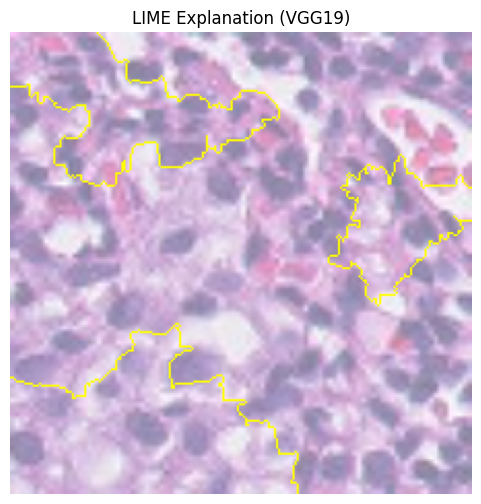

In [162]:
def transform_img_fn(x_array):
    return x_array.astype('double')

n_image = 10  
img = x_test[n_image].numpy()  
img_exp = np.expand_dims(img, axis=0) 

pred_probs = vgg_model.predict(img_exp)[0][0]
pred_label = int(pred_probs > 0.5)
true_label = y_test[n_image]

print(f"Predicted label: {pred_label} ({'Tumor' if pred_label else 'Normal'})")
print(f"True label    : {true_label} ({'Tumor' if true_label else 'Normal'})")

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image=img.astype('double'),
    classifier_fn=lambda x: vgg_model.predict(x),
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)

plt.figure(figsize=(6, 6))
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title("LIME Explanation (VGG19)")
plt.axis('off')
plt.show()

# Conclusions

This project explored three distinct strategies for classifying histopathology images from the PatchCamelyon (PCam) dataset, aiming to distinguish cancerous tissue from healthy regions. The approaches included: (1) feature extraction with classical classifiers; (2) hybrid feature fusion across multiple CNNs; and (3) end-to-end training of a custom lightweight CNN. Each was systematically evaluated using accuracy, precision, recall, F1-score, and AUC on validation and test data.

---

**Approach 1: Feature Extraction + Classical Classifiers**

The first approach leveraged pretrained CNNs (MobileNetV2, VGG19, InceptionV3) as frozen feature extractors. These embeddings were passed to traditional classifiers such as SVM, Decision Tree, Naïve Bayes, and KNN.

* **VGG19** showed the highest overall AUC (0.80) and accuracy (\~73%), likely due to its uniform depth and stable spatial filters.
* **MobileNetV2** achieved strong performance with KNN (AUC = 0.78), benefitting from efficient and stain-sensitive filters.
* **InceptionV3** lagged behind with lower accuracy (\~61%) and AUC (0.68–0.76), possibly due to over-abstracted features unsuitable for fine-grained PCam textures.
* **KNN** consistently delivered top performance across models, suggesting the embeddings formed tight clusters in feature space.
* **Decision Trees** underperformed, indicating sensitivity to noise and overfitting in high-dimensional input spaces.

*Conclusion*: Pretrained CNNs, even when frozen, extract meaningful representations that allow traditional classifiers—especially KNN and Naïve Bayes—to achieve respectable performance. VGG19 was the most effective backbone for this paradigm.

---

**Approach 2: Hybrid Feature Fusion**

This strategy combined the strengths of all three CNNs by concatenating their embeddings into a single hybrid representation. The resulting vectors were used to train the same set of classifiers.

* **KNN (AUC = 0.81)** and **Naïve Bayes (AUC = 0.79)** achieved the best results, with balanced accuracy and F1-scores around 76%.
* **SVM** and **Decision Trees** struggled more than in the previous approach due to the high-dimensional, fused feature space.
* The hybrid vector appeared to preserve complementary information from each model (e.g., texture from VGG, color adaptation from MobileNet, contextual features from Inception).

*Conclusion*: Feature fusion is a viable and effective strategy for boosting classification performance, particularly for algorithms capable of handling redundancy (e.g., KNN, Naïve Bayes). The approach enriched the feature space with diverse visual cues, supporting better generalization.

---

**Approach 3: End-to-End CNN Classifiers**

The third phase of the project involved full fine-tuning of four convolutional neural networks—**MobileNetV2**, **VGG19**, **InceptionV3**, and a custom-built CNN\*\*—each trained end-to-end for tumor classification.

* **VGG19** emerged as the top-performing model overall, achieving **accuracy = 79.8%**, **precision = 0.82**, and the highest **AUC = 0.880**. Its frozen convolutional layers, combined with a regularized dense head, proved effective at capturing nuclear and texture-level patterns in PCam patches.
* **MobileNetV2** closely followed with **accuracy = 79.2%** and **AUC = 0.873**, benefiting from its lightweight architecture and partial layer unfreezing, which allowed it to adapt to stain-specific features.
* The **custom CNN**, though significantly shallower, achieved **accuracy = 70.6%** and **AUC = 0.796**. It demonstrated strong **precision (0.805)** but lower **recall (0.544)**, indicating conservative predictions that favored specificity over sensitivity.
* **InceptionV3** underperformed relative to all other models, with **accuracy = 62.2%** and **AUC = 0.678**. Its multi-scale architecture, although powerful, may have failed to focus adequately on the fine-grained patterns typical of PCam images.

*Conclusion*: Fine-tuning CNNs end-to-end on PCam patches is highly effective when the model architecture aligns with the scale and texture complexity of the task. While deeper models like VGG19 achieved top performance, **compact architectures (MobileNetV2, Custom CNN)** showed that **efficiency and accuracy can coexist**. InceptionV3, though architecturally advanced, may not be well-suited for this fixed-scale, texture-dominated domain.

---

**Overall Takeaways**

* **Best performer**: VGG19, with the highest AUC (0.880), precision, and accuracy across all fine-tuned models.
* **Best generalization-efficiency trade-off**: MobileNetV2, due to its smaller footprint and nearly identical performance to VGG19.
* **Most improved through fusion**: The hybrid representation outperformed all individual feature extractors when combined with KNN.
* **Simplest viable solution**: The custom CNN outperformed InceptionV3, showing promise as a deployable model under computational constraints.

---

**Strategic Insights**

* CNNs with **uniform and local receptive fields** (e.g., VGG, MobileNet) align better with PCam’s fixed-scale patch size than multi-scale architectures like Inception.
* **Regularization and shallow classification heads** are key to controlling overfitting in small medical datasets.
* **Feature fusion** enhances representation richness, especially when model diversity is exploited.
* Simple CNNs can compete—if well-regularized and tailored—but risk missing subtle tumor regions without deeper context.

# Further improvements

To further boost performance and mitigate overfitting, future work could explore the following strategies:

### 1. **Data-Level Enhancements**

* Apply **advanced stain normalization** (e.g., Macenko, Reinhard) to reduce inter-sample color variability.
* Introduce **stronger augmentation techniques**, such as MixUp, CutMix, random elastic deformations, or stain jittering.
* Implement **test-time augmentation (TTA)** to ensemble predictions from multiple transformed versions of the same patch.
* Use **multi-patch ensembling** or **context-aware cropping** to go beyond isolated 96×96 tiles and incorporate broader tissue context.

### 2. **Architectural Improvements**

* Adopt **progressive layer unfreezing** with **discriminative learning rates** to fine-tune different parts of the backbone adaptively.
* Integrate **attention mechanisms** (e.g., SE-blocks, CBAM) to highlight diagnostically relevant cellular regions.
* Explore **lightweight detection or segmentation backbones** to first localize regions of interest before classification.
* Build **ensembles of complementary architectures** (e.g., combining VGG19 and MobileNetV2) to reduce model variance and improve generalization.

### 3. **Regularization & Optimization**

* Employ **cyclical learning rates** (CLR) or a **one-cycle policy** to promote better convergence and generalization.
* Use **stochastic weight averaging (SWA)** to smooth the loss landscape and improve final performance.
* Reinforce **regularization** through L2 penalties on convolutional weights and normalization layers such as **GroupNorm** or **LayerNorm**.
* Extend **early stopping criteria** to include additional metrics (e.g., AUC or F1) alongside validation loss.

### 4. **Training Strategies**

* Implement **k-fold cross-validation** to fully exploit the dataset and obtain more robust generalization estimates.
* Incorporate **hard example mining** or **focal loss** to focus learning on difficult or ambiguous patches.
* Explore **semi-supervised** or **self-supervised pretraining** on unlabeled histopathology slides to learn domain-specific visual representations.
* Apply **curriculum learning**, introducing samples in increasing difficulty to stabilize and guide the learning process.

### 5. **Evaluation & Deployment**

* Apply **probability calibration methods** (e.g., temperature scaling) to produce well-calibrated outputs suitable for clinical decision-making.
* Extend **explainability** beyond LIME by comparing Grad-CAM, Integrated Gradients, and SHAP to ensure interpretability and consistency.
* Incorporate **uncertainty estimation** techniques (e.g., Monte Carlo dropout, deep ensembles) to flag low-confidence predictions for human review or deferred diagnosis.

Implementing these improvements would help strengthen model robustness, interpretability, and reliability—paving the way for safe and effective deployment of AI-assisted diagnostic tools in clinical pathology.